In [1]:
import math
import numpy as np
import scipy as sc
import scipy.optimize
import PyPDF2 as pypdf
import json
import os
from pdf2image import convert_from_path
import cv2
from functools import reduce
import sys

Function find QRs from pyexams.scan

In [2]:
from pyexams.scan import find_qrs
from pyexams.scan import analyse_scanned
from pyexams.scan import is_marked
from pyexams.scan import is_valid_box

In [3]:
dpi = 300

Transformation function by pang

In [4]:
def rot(alpha):
    '''clockwise rotation

    :param: alpha in 360 degrees
    '''
    alpha_rad = alpha*np.pi/180
    return np.array([
        [np.cos(alpha_rad), np.sin(alpha_rad)],
        [-np.sin(alpha_rad), np.cos(alpha_rad)]
    ])

In [5]:
def trans(C1, C2):
    def sq(xs):
        x0, y0, scale, angle = xs
        C1_trans = np.array([[x0,y0]]) + scale*C1@rot(angle)
        return ((C1_trans - C2)**2).sum()
    x0_guess, y0_guess = C2[0,:] - C1[0,:]
    sol = sc.optimize.minimize(sq, (x0_guess, y0_guess, 1, 0), tol=1e-9, method='Powell')
    if not sol['success']:
        raise RuntimeError('Numerical error: could not find transformation matrix')
    return tuple(sol['x'])

# Transformation functions

- compare default coordinates with scan coordinates
- get rotation and scale by comparing the vectors
- get displacement by comparing the scan coordinates with the transformed (rotation and scale) default coordinates

In [203]:
def get_rotation(vector, vector_trans):
    prod = vector[0] * vector_trans[0] + vector[1] * vector_trans[1]
    d1 = math.sqrt(math.pow(vector[0], 2) + math.pow(vector[1], 2))
    d2 = math.sqrt(math.pow(vector_trans[0], 2) + math.pow(vector_trans[1], 2))
    cos = prod / (d1 * d2)
    cross_prod = vector[0] * vector_trans[1] - vector[1] * vector_trans[0]
    sin = cross_prod / (d1 * d2)
    scale = d2 / d1
    return (sin, cos), scale

In [204]:
def get_trans(points, points_trans):
    num_points = points.__len__()
    if not num_points == points_trans.__len__():
        return ()
    tr_cords = np.zeros((num_points,2))
    alpha_final, sin_final, cos_final, scale_final, dist_final = [0] * 5
    # find rotation alpha and scale
    for i in range(num_points):
        if i == num_points - 1:
            vector = [points[0,0] - points[i,0], points[0,1] - points[i,1]]
            vector_trans = [points_trans[0,0] - points_trans[i,0], points_trans[0,1] - points_trans[i,1]]
        else:
            vector = [points[i+1,0] - points[i,0], points[i+1,1] - points[i,1]]
            vector_trans = [points_trans[i+1,0] - points_trans[i,0], points_trans[i+1,1] - points_trans[i,1]]
        (sin, cos), scale = get_rotation(vector, vector_trans)
        sin_final = sin_final + sin / num_points
        cos_final = cos_final + cos / num_points
        scale_final = scale_final + scale / num_points
    alpha_final = math.atan2(sin_final, cos_final) * 180 / np.pi
    # find translation
    for i in range(num_points):
        tr_cords[i] = scale_final * points[i] @ rot(alpha_final)
        dist = points_trans[i] - tr_cords[i]
        # print(dist)
        dist_final = dist_final + dist / num_points
    return dist_final, alpha_final, scale_final
    # tr_cords + dist_final

In [205]:
default_cords_qr, qr_cords2_180

(array([[1950.00012207, 3174.        ],
        [2107.        , 3174.        ],
        [2107.        , 3331.        ],
        [1950.00012207, 3331.        ]]),
 array([[570.        , 333.        ],
        [419.27383423, 335.9961853 ],
        [414.        , 182.        ],
        [570.92858887, 182.        ]]))

In [206]:
get_trans(default_cords_qr, qr_cords2_180)

(array([2510.77730138, 3407.93298911]), 179.3130420464907, 0.9757549200644493)

Statement files, for default coordinates

In [8]:
st_file1 = 'question/question_11111.pdf'
st_file2 = 'question/question_22222.pdf'
st_file3 = 'question/question_33333.pdf'
st_file4 = 'question/question_44444.pdf'

Solution files, for scanned coordinates

In [9]:
ex_file1 = 'scanned/scanned_11111.pdf'
ex_file2 = 'scanned/scanned_22222.pdf'

# filled ones should have the same coords
ex_file3 = 'scanned/filled_33333.pdf'
ex_file4 = 'scanned/filled_44444.pdf'

# filled 3 rotated by 90º and 180º
ex_file2_rot90 = 'scanned/scanned_22222_rot90.pdf'
ex_file2_rot180 = 'scanned/scanned_22222_rot180.pdf'
ex_file3_rot90 = 'scanned/filled_33333_rot90.pdf'
ex_file3_rot180 = 'scanned/filled_33333_rot180.pdf'

# Test different angles of transformation for QR detection

- Does OpenCV QR detection work with QRs with a significant angle?
- Rotated filled_33333 and scanned_22222 by 90º and 180º with ilovepdf.com
- QR detection still works
- Check transformation with pang's function

In [10]:
qrs3 = find_qrs(ex_file3, dpi)
qrs3_rot90 = find_qrs(ex_file3_rot90, dpi)
qrs3_rot180 = find_qrs(ex_file3_rot180, dpi)

In [11]:
qr_cords3, qr_cords3_90, qr_cords3_180 = np.zeros((4,2)), np.zeros((4,2)), np.zeros((4,2))
# qr_cords3, qr_cords3_90, qr_cords3_180 = np.zeros((12,2)), np.zeros((12,2)), np.zeros((12,2))
for page in range(1):
    for point in range(4):
        qr_cords3[page*4+point] = (qrs3[page]['coordinates'][0][point])
        qr_cords3_90[page*4+point] = (qrs3_rot90[page]['coordinates'][0][point])
        qr_cords3_180[page*4+point] = (qrs3_rot180[page]['coordinates'][0][point])

In [12]:
print(qr_cords3)
print(qr_cords3_90)
print(qr_cords3_180)

[[1950.00012207 3174.        ]
 [2107.         3174.        ]
 [2107.         3331.        ]
 [1950.00012207 3331.        ]]
[[ 333. 1950.]
 [ 333. 2107.]
 [ 175. 2107.]
 [ 175. 1950.]]
[[530. 333.]
 [372. 333.]
 [372. 175.]
 [530. 175.]]


In [59]:
qrs2 = find_qrs(ex_file2, dpi)
qrs2_rot90 = find_qrs(ex_file2_rot90, dpi)
qrs2_rot180 = find_qrs(ex_file2_rot180, dpi)

In [60]:
qr_cords2, qr_cords2_90, qr_cords2_180 = np.zeros((4,2)), np.zeros((4,2)), np.zeros((4,2))
# qr_cords3, qr_cords3_90, qr_cords3_180 = np.zeros((12,2)), np.zeros((12,2)), np.zeros((12,2))
for page in range(1):
    for point in range(4):
        qr_cords2[page*4+point] = (qrs2[page]['coordinates'][0][point])
        qr_cords2_90[page*4+point] = (qrs2_rot90[page]['coordinates'][0][point])
        qr_cords2_180[page*4+point] = (qrs2_rot180[page]['coordinates'][0][point])

In [61]:
print(qr_cords2)
print(qr_cords2_90)
print(qr_cords2_180)

[[1892.         3101.        ]
 [2042.72619629 3098.00390625]
 [2048.         3252.        ]
 [1891.07141113 3252.        ]]
[[3101.          570.        ]
 [3098.00390625  419.27383423]
 [3252.          414.        ]
 [3252.          570.92858887]]
[[570.         333.        ]
 [419.27383423 335.9961853 ]
 [414.         182.        ]
 [570.92858887 182.        ]]


In [13]:
get_trans(qr_cords3, qr_cords3_90)

(array([3516.85954469,   -6.46104091]), 90.0, 1.0031851021350553)

# Tests to correct the coordinates of checkboxes to account for scanned exam displacement

- Get default coordinates for the QR points (in OpenCV)

In [14]:
dpi = 300

In [15]:
qr_codes1 = find_qrs(st_file1, dpi)
qr_codes1

[{'exam': 'test_qr',
  'variant': '11111',
  'page': '1',
  'coordinates': array([[[1950.0001, 3174.    ],
          [2107.    , 3174.    ],
          [2107.    , 3331.    ],
          [1950.0001, 3331.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '2',
  'coordinates': array([[[1950.0001, 3174.    ],
          [2107.    , 3174.    ],
          [2107.    , 3331.    ],
          [1950.0001, 3331.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '3',
  'coordinates': array([[[1950.0001, 3174.    ],
          [2107.    , 3174.    ],
          [2107.    , 3331.    ],
          [1950.0001, 3331.    ]]], dtype=float32)}]

In [16]:
default_cords_qr = np.zeros((4,2))
for page in range(1):
    for point in range(4):
        default_cords_qr[page * 4 + point] = (qr_codes1[page]['coordinates'][0][point])
default_cords_qr/dpi

array([[ 6.50000041, 10.58      ],
       [ 7.02333333, 10.58      ],
       [ 7.02333333, 11.10333333],
       [ 6.50000041, 11.10333333]])

- Get coordinates of the QRs in the scans

In [17]:
scan1_qrs = find_qrs(ex_file1, dpi)
scan1_qrs

[{'exam': 'test_qr',
  'variant': '11111',
  'page': '1',
  'coordinates': array([[[1894.9999, 3098.0002],
          [2046.6063, 3098.0002],
          [2049.    , 3250.    ],
          [1895.    , 3250.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '2',
  'coordinates': array([[[1928.    , 3060.    ],
          [2078.945 , 3057.2483],
          [2082.    , 3210.    ],
          [1930.    , 3206.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '3',
  'coordinates': array([[[1893.    , 3099.    ],
          [2045.    , 3099.    ],
          [2045.0001, 3251.    ],
          [1893.    , 3251.    ]]], dtype=float32)}]

In [18]:
scan1_1_cords_qr = np.zeros((4,2))
scan1_2_cords_qr = np.zeros((4,2))
scan1_3_cords_qr = np.zeros((4,2))
for page in range(1):
    for point in range(4):
        scan1_1_cords_qr[page * 4 + point] = (scan1_qrs[0]['coordinates'][0][point])
        scan1_2_cords_qr[page * 4 + point] = (scan1_qrs[1]['coordinates'][0][point])
        scan1_3_cords_qr[page * 4 + point] = (scan1_qrs[2]['coordinates'][0][point])
scan1_1_cords_qr

array([[1894.99987793, 3098.00024414],
       [2046.60632324, 3098.00024414],
       [2049.        , 3250.        ],
       [1895.        , 3250.        ]])

- OpenCV default to OpenCV scanned transformation, with pang's function

In [19]:
transform_scan1_1 = get_trans(default_cords_qr, scan1_1_cords_qr)
transform_scan1_2 = get_trans(default_cords_qr, scan1_2_cords_qr)
transform_scan1_3 = get_trans(default_cords_qr, scan1_3_cords_qr)
print(transform_scan1_1)
print(transform_scan1_2)
print(transform_scan1_3)

(array([-10.1602933 ,  24.44329335]), -0.22556489486545087, 0.9707405114126232)
(array([40.8854769 , 28.91844724]), -0.3668730426588277, 0.9583104430084134)
(array([ 5.1000921 , 26.08134055]), -1.1506163972606616e-05, 0.968153437000137)


In [20]:
dist, alpha, scale = transform_scan1_1
dist + scale * default_cords_qr @ rot(alpha)

array([[1894.8990704 , 3098.09758174],
       [2047.30403114, 3097.49758316],
       [2047.90403019, 3249.9026624 ],
       [1895.49906945, 3250.50266098]])

- Get default coordinates of checkboxes in example exam (in pyPDF2 and OpenCV)

In [21]:
st_json_file1 = 'json/question_11111.json'
with open(st_json_file1) as json_file:
    data_st1 = json.load(json_file)
data_st1

{'exam': 'test_qr',
 'variant': '11111',
 'num_boxes': 67,
 'exercises': [{'exercise': 'vf1',
   'checkboxes': [{'checkbox': '0,0',
     'cords': [105.961, 383.659, 12.716, 12.716],
     'page': 1},
    {'checkbox': '0,1',
     'cords': [105.961, 367.719, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf2',
   'checkboxes': [{'checkbox': '1,0',
     'cords': [105.961, 324.103, 12.716, 12.717],
     'page': 1},
    {'checkbox': '1,1',
     'cords': [105.961, 308.163, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf3',
   'checkboxes': [{'checkbox': '2,0',
     'cords': [105.961, 265.739, 12.716, 12.716],
     'page': 1},
    {'checkbox': '2,1',
     'cords': [105.961, 249.799, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf4',
   'checkboxes': [{'checkbox': '3,0',
     'cords': [105.961, 207.375, 12.716, 12.716],
     'page': 1},
    {'checkbox': '3,1',
     'cords': [105.961, 191.434, 12.716, 12.717],
     'page': 1}]},
  {'exercise': 'vf5',
   'checkboxes': [{'checkb

In [22]:
default_coords_pypdf_boxes = np.zeros((data_st1['num_boxes'],2))
count_ex = 0
count_box = 0
for i in range(data_st1['num_boxes']):
    if count_box == data_st1['exercises'][count_ex]['checkboxes'].__len__():
        count_ex = count_ex + 1
        count_box = 0
    default_coords_pypdf_boxes[i] = data_st1['exercises'][count_ex]['checkboxes'][count_box]['cords'][0:2]
    count_box = count_box + 1
default_coords_pypdf_boxes

array([[105.961, 383.659],
       [105.961, 367.719],
       [105.961, 324.103],
       [105.961, 308.163],
       [105.961, 265.739],
       [105.961, 249.799],
       [105.961, 207.375],
       [105.961, 191.434],
       [105.961, 148.459],
       [105.961, 132.518],
       [105.961,  90.094],
       [105.961,  74.154],
       [105.961, 713.121],
       [105.961, 697.181],
       [105.961, 681.241],
       [105.961, 665.301],
       [105.961, 622.323],
       [105.961, 606.383],
       [105.961, 590.443],
       [105.961, 574.502],
       [105.961, 531.303],
       [105.961, 515.363],
       [105.961, 499.423],
       [105.961, 483.483],
       [105.961, 439.646],
       [105.961, 423.706],
       [105.961, 407.765],
       [105.961, 391.825],
       [105.961, 347.989],
       [105.961, 332.048],
       [105.961, 316.108],
       [105.961, 272.271],
       [105.961, 256.331],
       [105.961, 240.391],
       [105.961, 224.451],
       [105.961, 181.252],
       [105.961, 165.311],
 

- checkbox coordinates with openCV
- it seems to take one QR point as a checkbox, filter it out by removing marked boxes

In [23]:
dpi = 400

In [24]:
opencv_boxes = analyse_scanned('scanned/question_11111.pdf', dpi, qr_codes1)
coords_opencv_boxes = np.zeros((data_st1['num_boxes'],2))
count = 0
for box in (opencv_boxes['boxes']):
    if not box['is_marked']:
        coords_opencv_boxes[count] = box['stats'][0:2]
        count = count + 1
coords_opencv_boxes

array([[ 524., 2481.],
       [ 524., 2569.],
       [ 524., 2811.],
       [ 524., 2900.],
       [ 524., 3136.],
       [ 524., 3224.],
       [ 524., 3460.],
       [ 524., 3549.],
       [ 524., 3787.],
       [ 524., 3876.],
       [ 524., 4112.],
       [ 524., 4200.],
       [ 524.,  650.],
       [ 524.,  739.],
       [ 524.,  827.],
       [ 524.,  916.],
       [ 524., 1155.],
       [ 524., 1243.],
       [ 524., 1332.],
       [ 524., 1420.],
       [ 524., 1660.],
       [ 524., 1749.],
       [ 524., 1837.],
       [ 524., 1926.],
       [ 524., 2170.],
       [ 524., 2258.],
       [ 524., 2347.],
       [ 524., 2435.],
       [ 524., 2679.],
       [ 524., 2767.],
       [ 524., 2856.],
       [ 524., 3099.],
       [ 524., 3188.],
       [ 524., 3277.],
       [ 524., 3365.],
       [ 524., 3605.],
       [ 524., 3694.],
       [ 524., 3782.],
       [ 524., 3871.],
       [ 524.,  650.],
       [ 524.,  739.],
       [ 524.,  827.],
       [ 524.,  916.],
       [ 52

- pyPDF2 default to OpenCV default transformation, with pang's?

In [25]:
transformations = []

In [26]:
dist, alpha, scale = get_trans(default_coords_pypdf_boxes, coords_opencv_boxes)
print(dist, alpha, scale)
transformations.append((dpi, dist, alpha, scale))
dist + scale * default_coords_pypdf_boxes @ rot(alpha)

[1112.59362591 4611.7485156 ] 180.0000000000002 5.554813808025848


array([[ 524.        , 2480.59420482],
       [ 524.        , 2569.13793692],
       [ 524.        , 2811.41669597],
       [ 524.        , 2899.96042807],
       [ 524.        , 3135.61784907],
       [ 524.        , 3224.16158117],
       [ 524.        , 3459.81900216],
       [ 524.        , 3548.36828907],
       [ 524.        , 3787.08641247],
       [ 524.        , 3875.63569939],
       [ 524.        , 4111.29312038],
       [ 524.        , 4199.83685248],
       [ 524.        ,  650.494138  ],
       [ 524.        ,  739.0378701 ],
       [ 524.        ,  827.5816022 ],
       [ 524.        ,  916.1253343 ],
       [ 524.        , 1154.86012214],
       [ 524.        , 1243.40385424],
       [ 524.        , 1331.94758634],
       [ 524.        , 1420.49687326],
       [ 524.        , 1660.45927495],
       [ 524.        , 1749.00300705],
       [ 524.        , 1837.54673915],
       [ 524.        , 1926.09047125],
       [ 524.        , 2169.59684415],
       [ 524.        , 22

In [27]:
get_trans(np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]), scan1_1_cords_qr)

(array([-4.11165693, 34.20214959]), -0.22556489486545087, 290.2975255011697)

In [28]:
(x0, y0), aplha, scale = get_trans(np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]), scan1_1_cords_qr)
x0, y0, aplha, scale

(-4.111656927748982,
 34.20214958516681,
 -0.22556489486545087,
 290.2975255011697)

In [29]:
transformations

[(400,
  array([1112.59362591, 4611.7485156 ]),
  180.0000000000002,
  5.554813808025848)]

In [30]:
dpi_list = [tr_i[0] for tr_i in transformations]
x0_list = [tr_i[1][0] for tr_i in transformations]
y0_list = [tr_i[1][1] for tr_i in transformations]
alpha_list = [tr_i[2] for tr_i in transformations]
scale_list = [tr_i[3] for tr_i in transformations]
for i in zip(dpi_list, x0_list, y0_list, alpha_list, scale_list):
    print(i[0], i[1]/i[0], i[2]/i[0], i[3], i[4]/i[0])

400 2.7814840647805514 11.529371288992671 180.0000000000002 0.013887034520064621


In [31]:
coords_opencv_boxes - (dist + scale * default_coords_pypdf_boxes @ rot(alpha))

array([[ 30171.62247372, 109244.50982066],
       [ 30171.62247372, 104705.16726417],
       [ 30171.62247372,  92285.55039191],
       [ 30171.62247372,  87747.20783542],
       [ 30171.62247372,  75667.62561356],
       [ 30171.62247372,  71128.28305707],
       [ 30171.62247372,  59048.70083521],
       [ 30171.62247372,  54510.06798119],
       [ 30171.62247372,  42272.53182278],
       [ 30171.62247372,  37733.89896877],
       [ 30171.62247372,  25654.31674691],
       [ 30171.62247372,  21114.97419042],
       [ 30171.62247372, 203055.51316732],
       [ 30171.62247372, 198517.17061083],
       [ 30171.62247372, 193977.82805435],
       [ 30171.62247372, 189439.48549786],
       [ 30171.62247372, 177202.07844687],
       [ 30171.62247372, 172662.73589038],
       [ 30171.62247372, 168124.39333389],
       [ 30171.62247372, 163584.76047988],
       [ 30171.62247372, 151284.19767575],
       [ 30171.62247372, 146745.85511926],
       [ 30171.62247372, 142206.51256277],
       [ 30

# Test checkbox detection directly with the coordinates (for each page)

- get the transformation of the coordinates from the statement to the scanned version
- look for the boxes within a range proportional to the min_width (dpi * 0.14)
- look for contours within that range?

In [32]:
dpi = 300

In [51]:
"""x0_ini, y0_ini, alpha_ini, scale_ini = """
dpi * 2.78148, dpi * 11.52937, 180, dpi * 0.013887

(834.4440000000001, 3458.811, 180, 4.1661)

In [34]:
default_coords_pypdf_boxes[0:12], default_coords_pypdf_boxes[12:39], default_coords_pypdf_boxes[39:67]

(array([[105.961, 383.659],
        [105.961, 367.719],
        [105.961, 324.103],
        [105.961, 308.163],
        [105.961, 265.739],
        [105.961, 249.799],
        [105.961, 207.375],
        [105.961, 191.434],
        [105.961, 148.459],
        [105.961, 132.518],
        [105.961,  90.094],
        [105.961,  74.154]]),
 array([[105.961, 713.121],
        [105.961, 697.181],
        [105.961, 681.241],
        [105.961, 665.301],
        [105.961, 622.323],
        [105.961, 606.383],
        [105.961, 590.443],
        [105.961, 574.502],
        [105.961, 531.303],
        [105.961, 515.363],
        [105.961, 499.423],
        [105.961, 483.483],
        [105.961, 439.646],
        [105.961, 423.706],
        [105.961, 407.765],
        [105.961, 391.825],
        [105.961, 347.989],
        [105.961, 332.048],
        [105.961, 316.108],
        [105.961, 272.271],
        [105.961, 256.331],
        [105.961, 240.391],
        [105.961, 224.451],
        [105.961, 

In [35]:
qr_codes_scan1 = find_qrs(ex_file1, 300)

In [36]:
qr_codes_scan1

[{'exam': 'test_qr',
  'variant': '11111',
  'page': '1',
  'coordinates': array([[[1894.9999, 3098.0002],
          [2046.6063, 3098.0002],
          [2049.    , 3250.    ],
          [1895.    , 3250.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '2',
  'coordinates': array([[[1928.    , 3060.    ],
          [2078.945 , 3057.2483],
          [2082.    , 3210.    ],
          [1930.    , 3206.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '11111',
  'page': '3',
  'coordinates': array([[[1893.    , 3099.    ],
          [2045.    , 3099.    ],
          [2045.0001, 3251.    ],
          [1893.    , 3251.    ]]], dtype=float32)}]

In [37]:
default_cords_qr

array([[1950.00012207, 3174.        ],
       [2107.        , 3174.        ],
       [2107.        , 3331.        ],
       [1950.00012207, 3331.        ]])

In [126]:
def anal_sc_test(file, dpi, qr_codes, statement_data):
    img_file = 'img_temp.png'
    data = {
        'exam': qr_codes[0]['exam'],
        'variant': qr_codes[0]['variant'],
        'num_boxes': statement_data['num_boxes'],
        'exercises': []
    }
    pages_data = []
    pages = convert_from_path(file, dpi)
    # TODO: treat json data from default_coords_qr into pages, can be done in parent function
    #  for now just divide it manually
    pages_st_data = split_pages(statement_data)
    for i, page in enumerate(pages):
        if i < pages_st_data.__len__():
            st_page = pages_st_data[i]
        else:
            st_page = {'structure': [], 'coordinates': []}
        page.save(img_file)
        pages_data.append(
            anal_p_test(img_file, dpi, qr_codes[i]['page'], qr_codes[i]['coordinates'][0], st_page['structure'], np.array(st_page['coordinates']))
        )
    pages_data.sort(key=lambda k: k['page'])
    for page in pages_data:
        data['exercises'].append(page['exercises'])
    data['num_boxes'] = count
    return data

In [39]:
np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]) * dpi

array([[1950. , 3174. ],
       [2107.5, 3174. ],
       [2107.5, 3331.5],
       [1950. , 3331.5]])

Qué pasa si no detecta ningun contorno valido donde deberia encontrar la caja?
Cómo reconocer en el código cuando esto pasa

In [40]:
a = [(0,0), (1,1), (2,2), (3,3), ()]
for i in a:
    if i:
        a1, a2 = i
        print(a1, a2)
    else:
        print(i)

0 0
1 1
2 2
3 3
()


transform json data to split the structural info from the coordinates, from the coordinates, and to split all data by the page it belongs to
splitting by page is needed to check the boxes in each page
splitting structure from coords is needed to transform the coords in

In [41]:
data_st1

{'exam': 'test_qr',
 'variant': '11111',
 'num_boxes': 67,
 'exercises': [{'exercise': 'vf1',
   'checkboxes': [{'checkbox': '0,0',
     'cords': [105.961, 383.659, 12.716, 12.716],
     'page': 1},
    {'checkbox': '0,1',
     'cords': [105.961, 367.719, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf2',
   'checkboxes': [{'checkbox': '1,0',
     'cords': [105.961, 324.103, 12.716, 12.717],
     'page': 1},
    {'checkbox': '1,1',
     'cords': [105.961, 308.163, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf3',
   'checkboxes': [{'checkbox': '2,0',
     'cords': [105.961, 265.739, 12.716, 12.716],
     'page': 1},
    {'checkbox': '2,1',
     'cords': [105.961, 249.799, 12.716, 12.716],
     'page': 1}]},
  {'exercise': 'vf4',
   'checkboxes': [{'checkbox': '3,0',
     'cords': [105.961, 207.375, 12.716, 12.716],
     'page': 1},
    {'checkbox': '3,1',
     'cords': [105.961, 191.434, 12.716, 12.717],
     'page': 1}]},
  {'exercise': 'vf5',
   'checkboxes': [{'checkb

In [42]:
def split_pages(data):
    count_page = 1
    pages = [{'structure': [], 'coordinates': []}]
    for exercise in (data['exercises']):
        for checkbox in exercise['checkboxes']:
            while checkbox['page'] > count_page:
                count_page = count_page + 1
                pages.append({'structure': [], 'coordinates': []})
            pages[count_page - 1]['structure'].append({
                'exercise': exercise['exercise'],
                'checkbox': checkbox['checkbox']
            })
            pages[count_page - 1]['coordinates'].append([
                checkbox['cords'][0], checkbox['cords'][1]
            ])
    return pages

In [43]:
split_data_st1 = split_pages(data_st1)
split_data_st1

[{'structure': [{'exercise': 'vf1', 'checkbox': '0,0'},
   {'exercise': 'vf1', 'checkbox': '0,1'},
   {'exercise': 'vf2', 'checkbox': '1,0'},
   {'exercise': 'vf2', 'checkbox': '1,1'},
   {'exercise': 'vf3', 'checkbox': '2,0'},
   {'exercise': 'vf3', 'checkbox': '2,1'},
   {'exercise': 'vf4', 'checkbox': '3,0'},
   {'exercise': 'vf4', 'checkbox': '3,1'},
   {'exercise': 'vf5', 'checkbox': '4,0'},
   {'exercise': 'vf5', 'checkbox': '4,1'},
   {'exercise': 'vf6', 'checkbox': '5,0'},
   {'exercise': 'vf6', 'checkbox': '5,1'}],
  'coordinates': [[105.961, 383.659],
   [105.961, 367.719],
   [105.961, 324.103],
   [105.961, 308.163],
   [105.961, 265.739],
   [105.961, 249.799],
   [105.961, 207.375],
   [105.961, 191.434],
   [105.961, 148.459],
   [105.961, 132.518],
   [105.961, 90.094],
   [105.961, 74.154]]},
 {'structure': [{'exercise': 'mul1', 'checkbox': '6,0'},
   {'exercise': 'mul1', 'checkbox': '6,1'},
   {'exercise': 'mul1', 'checkbox': '6,2'},
   {'exercise': 'mul1', 'checkbox'

In [44]:
np.array(split_data_st1[0]['coordinates'])

array([[105.961, 383.659],
       [105.961, 367.719],
       [105.961, 324.103],
       [105.961, 308.163],
       [105.961, 265.739],
       [105.961, 249.799],
       [105.961, 207.375],
       [105.961, 191.434],
       [105.961, 148.459],
       [105.961, 132.518],
       [105.961,  90.094],
       [105.961,  74.154]])

In [45]:
split_data_st1[0]['structure']

[{'exercise': 'vf1', 'checkbox': '0,0'},
 {'exercise': 'vf1', 'checkbox': '0,1'},
 {'exercise': 'vf2', 'checkbox': '1,0'},
 {'exercise': 'vf2', 'checkbox': '1,1'},
 {'exercise': 'vf3', 'checkbox': '2,0'},
 {'exercise': 'vf3', 'checkbox': '2,1'},
 {'exercise': 'vf4', 'checkbox': '3,0'},
 {'exercise': 'vf4', 'checkbox': '3,1'},
 {'exercise': 'vf5', 'checkbox': '4,0'},
 {'exercise': 'vf5', 'checkbox': '4,1'},
 {'exercise': 'vf6', 'checkbox': '5,0'},
 {'exercise': 'vf6', 'checkbox': '5,1'}]

In [46]:
([[20, 20]] + [[12,12]] @ rot(180) * 0.5)

array([[14., 14.]])

In [47]:
import matplotlib.pyplot as plt

In [127]:
def preprocess_img(img, line_min_width, circle_min_width):
    gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    morph = cv2.morphologyEx(~gray_scale, cv2.MORPH_CLOSE, kernel)
    _, thresh = cv2.threshold(~morph, 0, 225, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_bin = ~thresh

    # filter the image to keep only horizontal and vertical lines of at least line_min_width
    kernel_h = np.ones((1, line_min_width), np.uint8)
    kernel_v = np.ones((line_min_width, 1), np.uint8)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_v)
    img_bin_squares = img_bin_h | img_bin_v

    # filter the image to keep only circles
    kernel_circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (circle_min_width, circle_min_width))
    img_bin_circles = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_circle)

    return img_bin, img_bin_squares, img_bin_circles

In [128]:
def find_amc_circles(amc_circles_expect, circle_min_width, img_bin_circle):
    amc_circles = []
    for circle in amc_circles_expect:
        # get area where the circle should be
        x_min, y_min= int(circle[0] - circle_min_width * 3), int(circle[1] - circle_min_width * 3)
        x_max, y_max = int(circle[0] + circle_min_width * 3), int(circle[1] + circle_min_width * 3)
        outer_box = img_bin_circle[y_min:y_max, x_min:x_max]
        contours, _ = cv2.findContours(~outer_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour = ()
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            x = x_min + x
            y = y_min + y
            if (circle_min_width < w < circle_min_width * 1.4) and (circle_min_width < h < circle_min_width * 1.4):
                contour = (x, y, w, h)
        if contour:
            x, y, w, h = contour
            amc_circles.append((x + w / 2,y + h / 2))
    return amc_circles

In [143]:
def find_checkbox(img_bin_squares, line_min_width, expected_x, expected_y):
    # get area where the box should be
    x_min, y_min= int(expected_x - line_min_width), int(expected_y - line_min_width)
    x_max, y_max = int(expected_x + line_min_width), int(expected_y + line_min_width)
    outer_box = img_bin_squares[y_min:y_max, x_min:x_max]
    # look for contours inside the area and keep the best one
    contours, hierarchy = cv2.findContours(~outer_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = ()
    area_max = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (line_min_width < w < line_min_width * 1.4) and (line_min_width < h < line_min_width * 1.4):
            if w * h > area_max:
                contour = (x, y, w, h)
                area_max = w * h
    # return checkbox location
    if not contour:
        # box not found, guess where it could be, less accurate
        x, y= (expected_x - line_min_width / 2), (expected_y - line_min_width / 2)
        w = h = line_min_width
    else:
        x, y, w, h = contour
        x = x_min + x
        y = y_min + y
    checkbox = ([x, y, w, h])
    return checkbox

In [247]:
def anal_p_test(file, dpi, page, qr_coordinates, st_structure, st_coordinates):
    img = cv2.imread(file)
    line_min_width = int(dpi * 0.17)
    circle_min_width = int(dpi * 0.13)
    data = {'page': page, 'exercises': []}
    img_bin, img_bin_squares, img_bin_circles = preprocess_img(img, line_min_width, circle_min_width)

    # values used to calculate the transformations
    x0_ini, y0_ini, alpha_ini, scale_ini = dpi * 2.78148, dpi * 11.529371, 180, dpi * 0.013887
    qr_default = np.array([[6.500,10.580], [7.025,10.580], [7.025,11.105], [6.500,11.105]]) * dpi
    amc_circles_default = np.array([[1.05333, 0.97], [7.21, 0.97], [1.05333, 11.03], [7.21, 11.03]]) * dpi
    (x0_scan, y0_scan), alpha_scan, scale_scan = get_trans(qr_default, qr_coordinates)

    # find amc circles
    amc_circles_expect = (x0_scan, y0_scan) + scale_scan * amc_circles_default @ rot(alpha_scan)+\
                         np.array([[circle_min_width/2, circle_min_width/2]]) @ rot(alpha_scan)
    amc_circles = find_amc_circles(amc_circles_expect, circle_min_width, img_bin_circles)
    # if it finds all 4 circles, update the transformation
    if amc_circles.__len__() == 4:
        circles = np.array(amc_circles)
        (x0_scan, y0_scan), alpha_scan, scale_scan = get_trans(amc_circles_default, circles)
        """"""
        for circle in circles:
            x, y = int(circle[0]), int(circle[1])
            d = int(circle_min_width / 2)
            cv2.rectangle(img,(x - d, y - d),(x + d, y + d),(255,0,0),2)

    # transform box coordinates from pyPDF2 to OpenCV, and correct for scan error
    coords_boxes = (x0_ini, y0_ini) + scale_ini * st_coordinates @ rot(alpha_ini)
    coords_boxes = (x0_scan, y0_scan) + scale_scan * coords_boxes @ rot(alpha_scan) +\
                   np.array([[line_min_width/2, line_min_width/2]]) @ rot(alpha_scan)

    # check the expected coordinates of each box
    stats = []
    last_ex = ''
    count_ex = -1
    fig, ax = plt.subplots(int(coords_boxes.__len__()/4) + 1, 4, figsize=(20, int(coords_boxes.__len__()/4)*5))
    count = 0
    for box_data, box in zip(st_structure, coords_boxes):
        i, j, = int(count/4), count%4
        count = count + 1
        exercise, checkbox = box_data['exercise'], box_data['checkbox']
        if exercise != last_ex:
            last_ex = exercise
            count_ex = count_ex + 1
            data['exercises'].append(
                {
                    'exercise': exercise,
                    'checkboxes': [],
                    'student_marked': []
                }
            )
        x, y, w, h = find_checkbox(img_bin_squares, line_min_width, box[0], box[1])
        x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
        inner_box = img_bin[y1:y2, x1:x2]
        ax[i,j].imshow(inner_box)
        marked = is_marked(inner_box, w, h)
        ax[i,j].set_title(str(marked))
        data['exercises'][count_ex]['checkboxes'].append(
            {
                'checkbox': checkbox,
                'cords': [x, y, round(w), round(h)],
                'page': page,
                'is_marked': marked
            }
        )
        if marked:
            data['exercises'][count_ex]['student_marked'].append(checkbox)
        cv2.rectangle(img,(x1, y1),(x2, y2),(0,255,0),2)

    plt.show()

    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

    return data

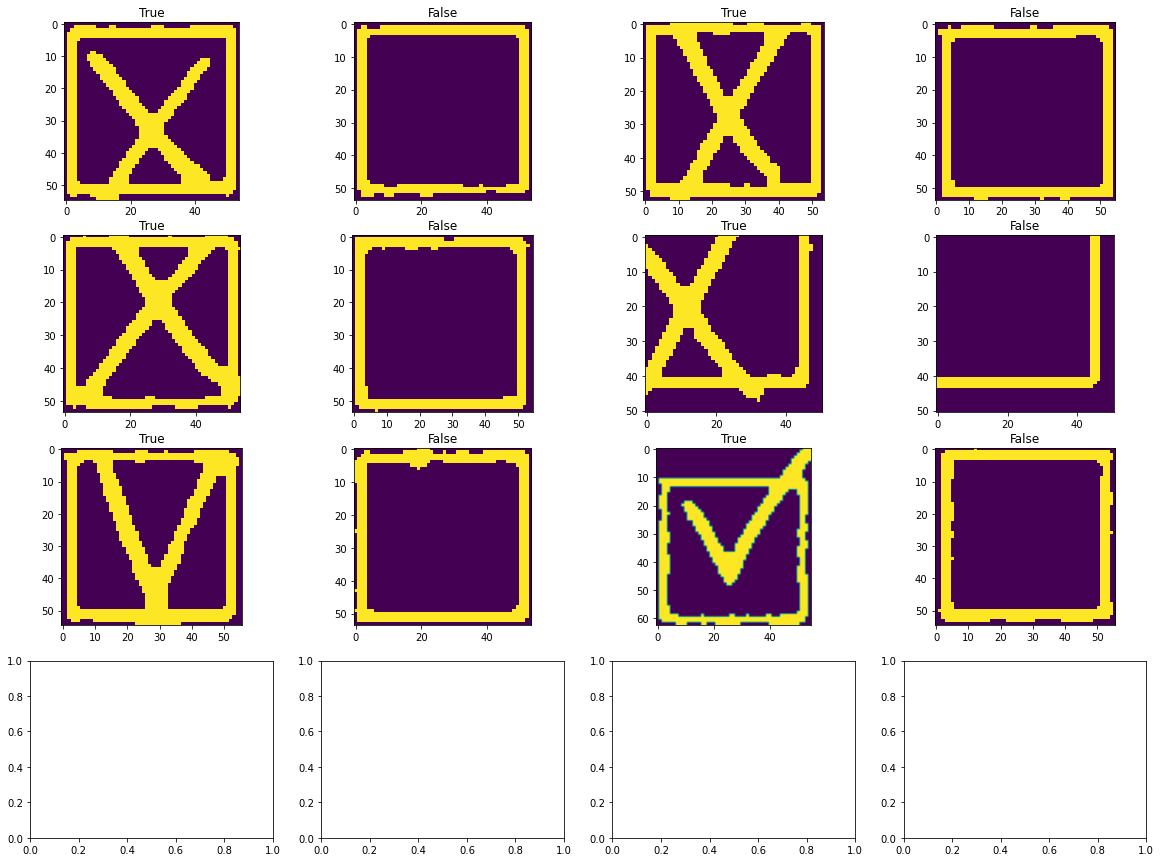

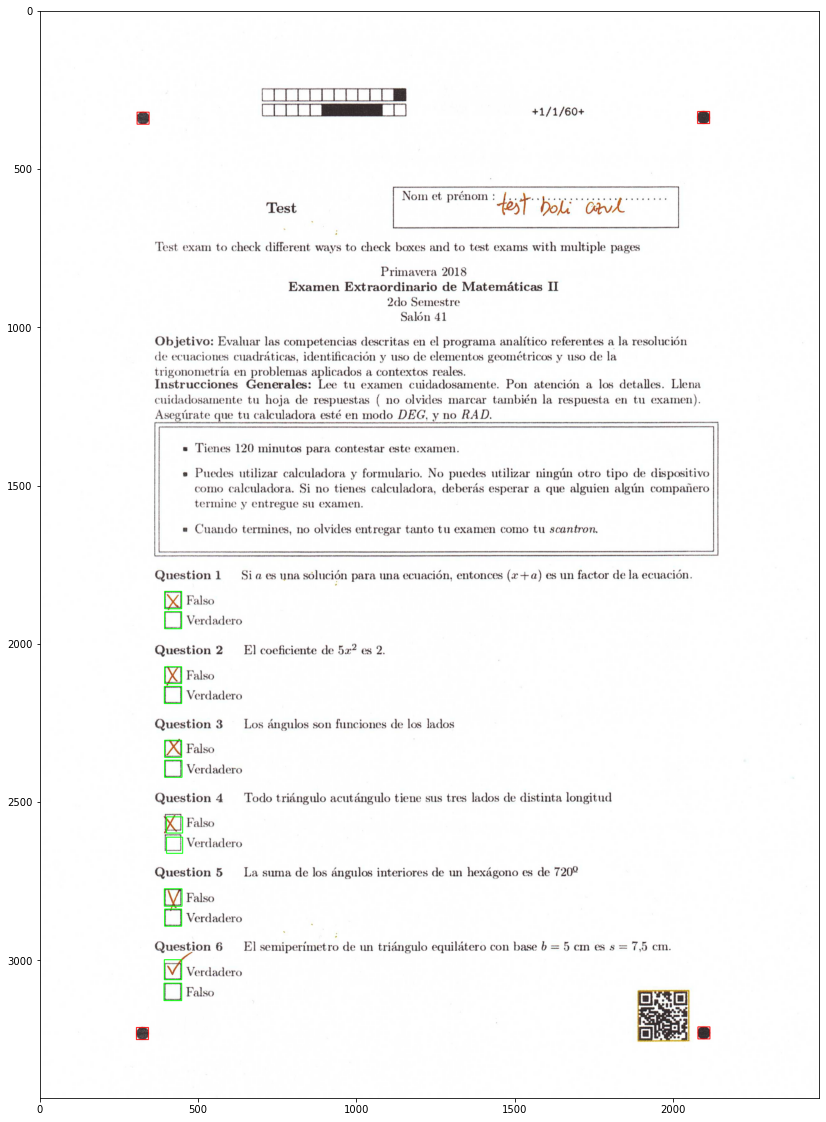

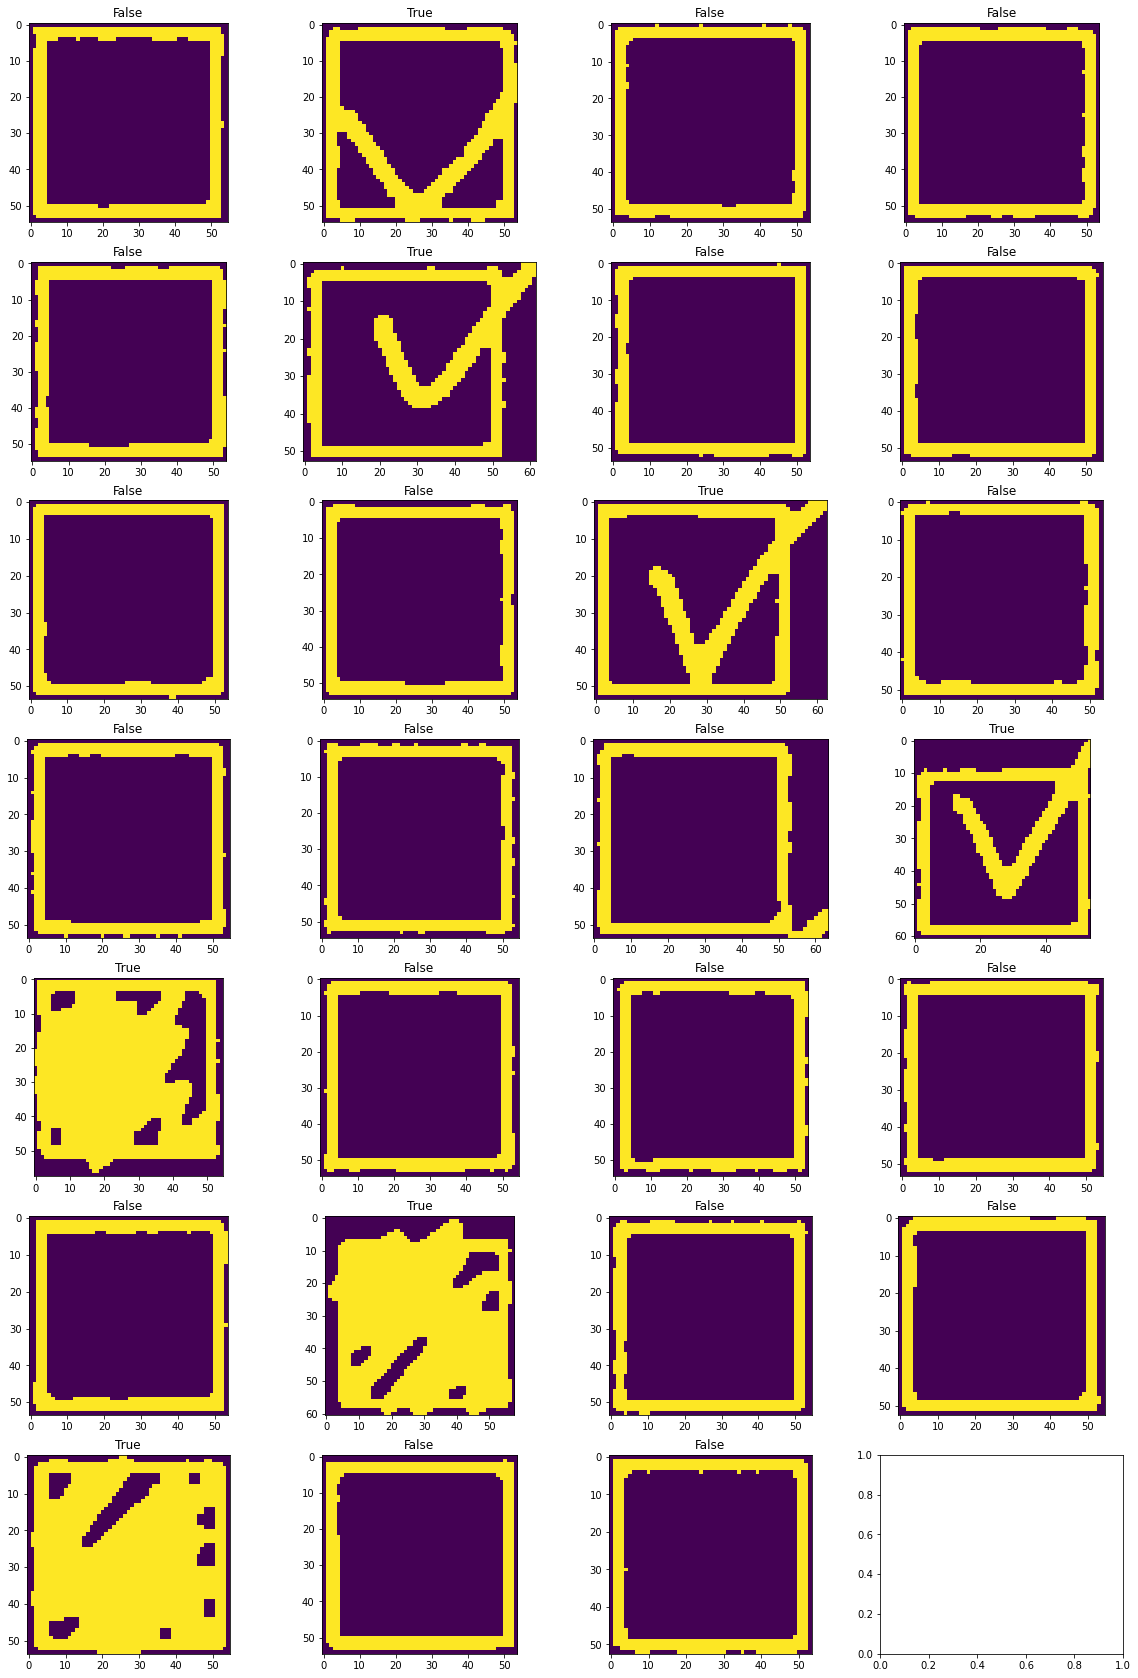

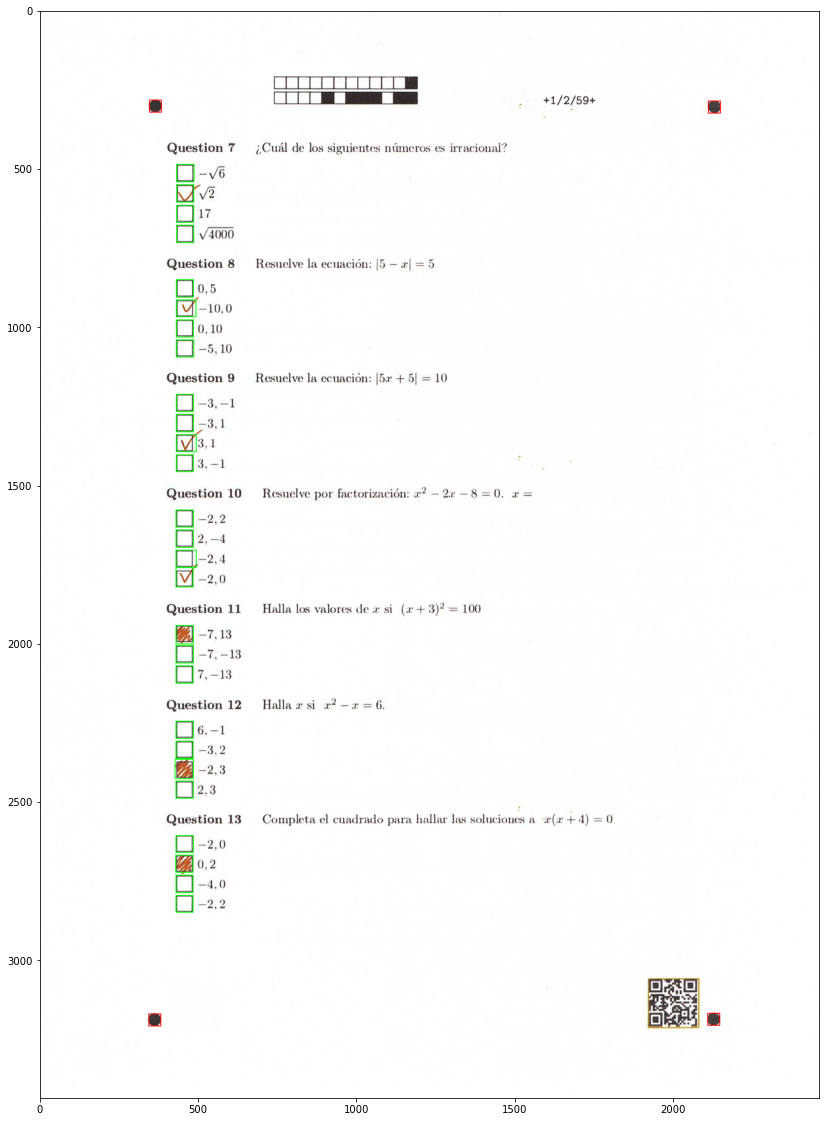

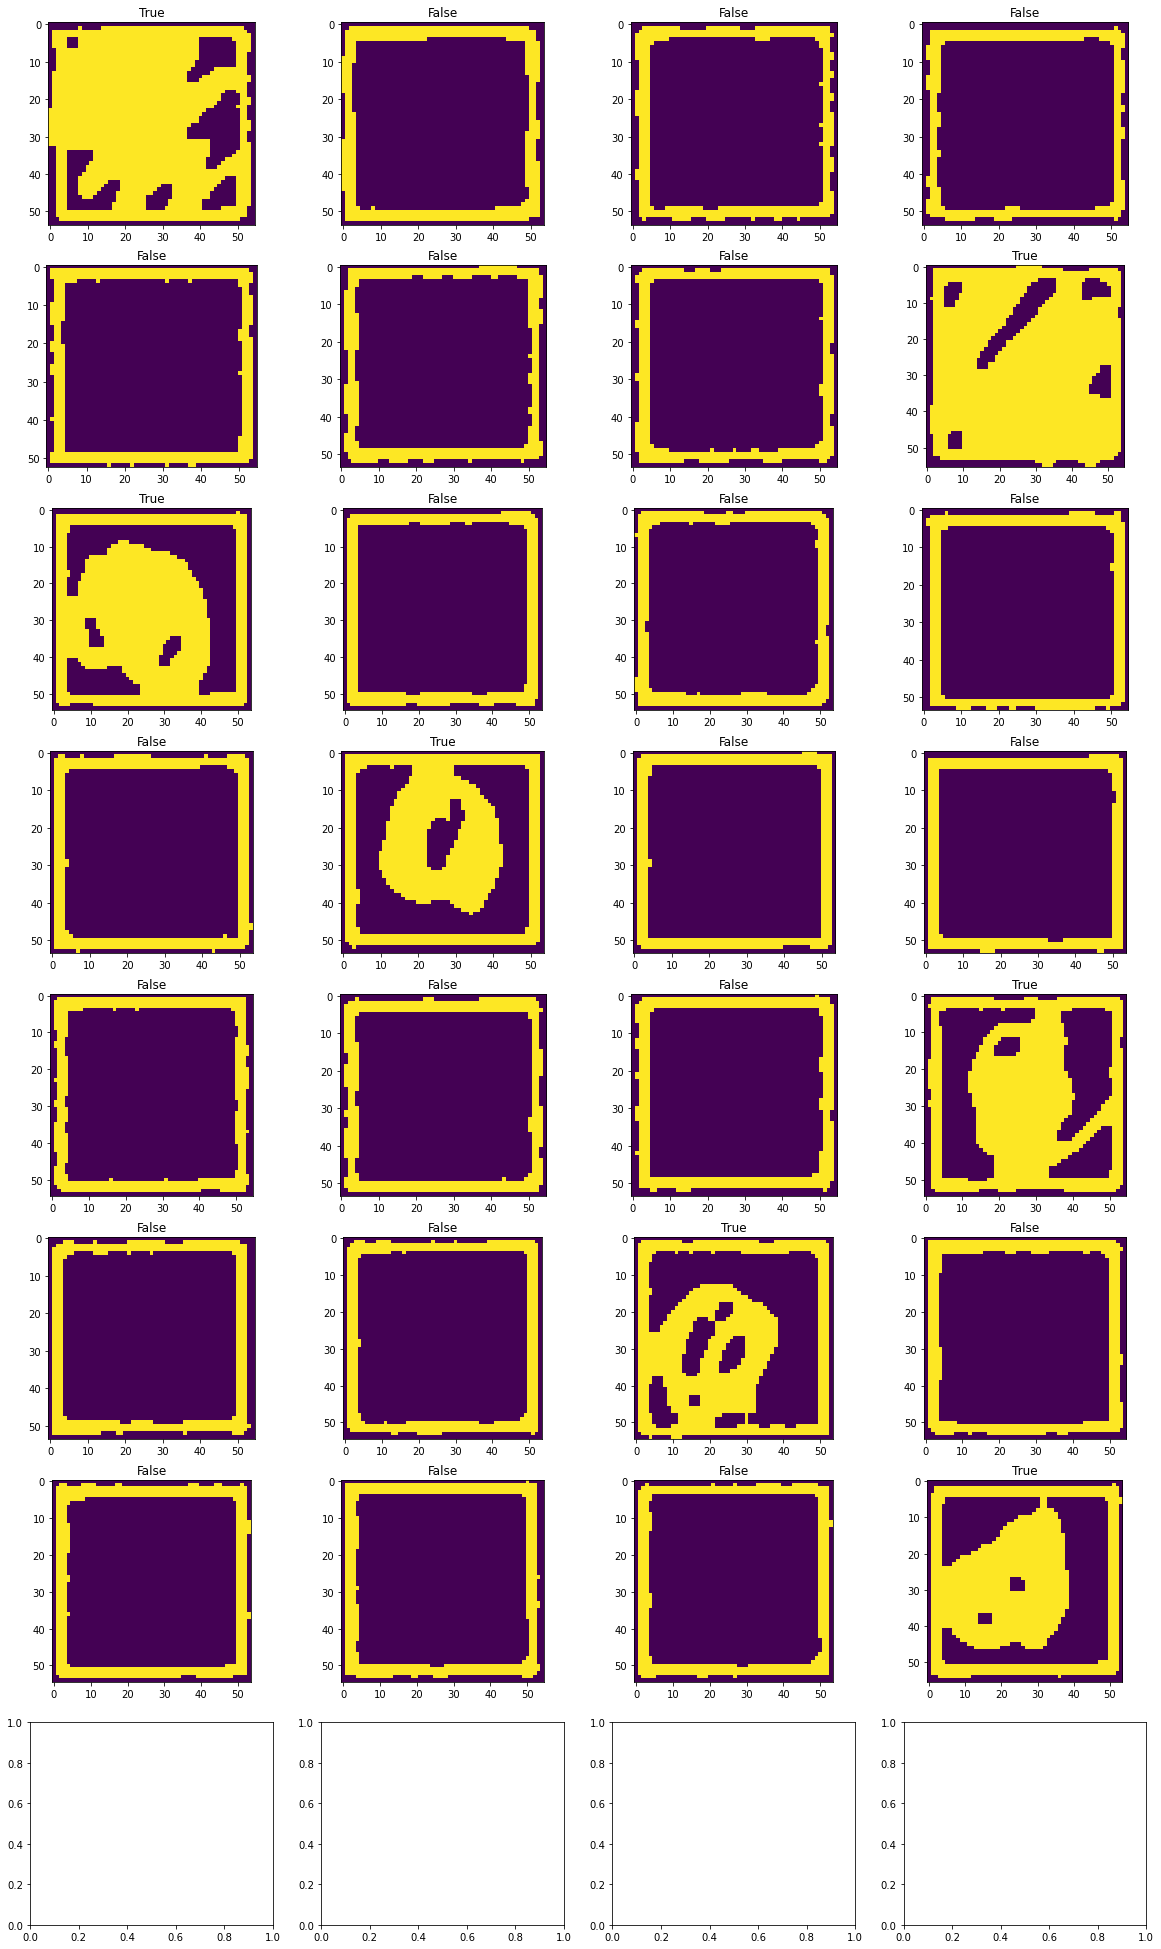

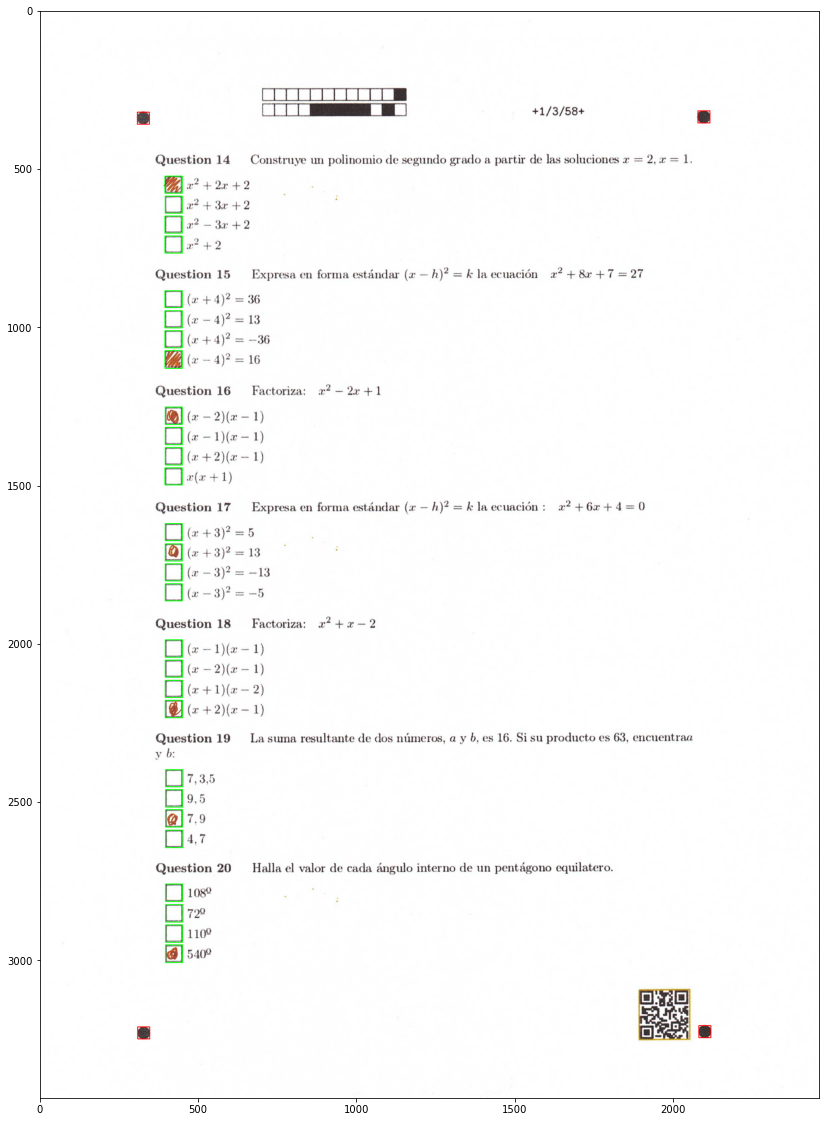

{'exam': 'test_qr',
 'variant': '22222',
 'num_boxes': 67,
 'exercises': [[{'exercise': 'vf1',
    'checkboxes': [{'checkbox': '0,0',
      'cords': [393, 1835, 54, 55],
      'page': '1',
      'is_marked': True},
     {'checkbox': '0,1',
      'cords': [393, 1899, 54, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['0,0']},
   {'exercise': 'vf2',
    'checkboxes': [{'checkbox': '1,0',
      'cords': [393, 2073, 54, 53],
      'page': '1',
      'is_marked': True},
     {'checkbox': '1,1',
      'cords': [392, 2135, 55, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['1,0']},
   {'exercise': 'vf3',
    'checkboxes': [{'checkbox': '2,0',
      'cords': [393, 2305, 54, 54],
      'page': '1',
      'is_marked': True},
     {'checkbox': '2,1',
      'cords': [393, 2368, 55, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['2,0']},
   {'exercise': 'vf4',
    'checkboxes': [{'checkbox': '3,0',
      'cords': [3

In [248]:
anal_sc_test(ex_file2, 300, qrs2, data_st1)

Las coordenadas en pyPDF son la [x_min, y_min,

In [249]:
pypdf.PdfFileReader(st_file1).getFields()

{'1:case:vf1:1,2': {'/T': '1:case:vf1:1,2',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 383.659, 105.961, 396.375]},
 '1:case:vf1:1,1': {'/T': '1:case:vf1:1,1',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 367.719, 105.961, 380.435]},
 '1:case:vf2:2,2': {'/T': '1:case:vf2:2,2',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 324.103, 105.961, 336.82]},
 '1:case:vf2:2,1': {'/T': '1:case:vf2:2,1',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 308.163, 105.961, 320.879]},
 '1:case:vf3:3,2': {'/T': '1:case:vf3:3,2',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 265.739, 105.961, 278.455]},
 '1:case:vf3:3,1': {'/T': '1:case:vf3:3,1',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 249.799, 105.961, 262.515]},
 '1:case:vf4:4,2': {'/T': '1:case:vf4:4,2',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 207.375, 105.961, 220.091]},
 '1:case:vf4:4,1': {'/T': '1:case:vf4:4,1',
  '/FT': '/Btn',
  '/V': '/Off',
  '/Rect': [93.245, 191.434, 105.961, 204.

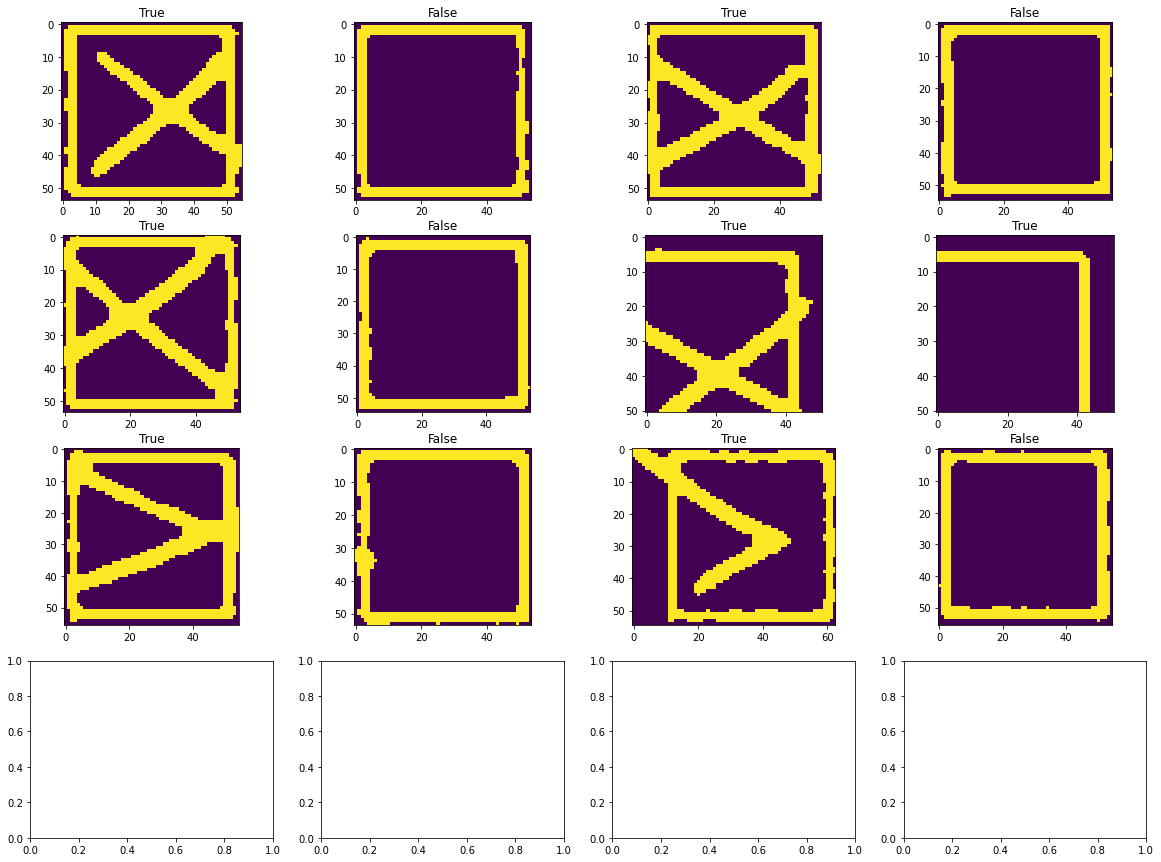

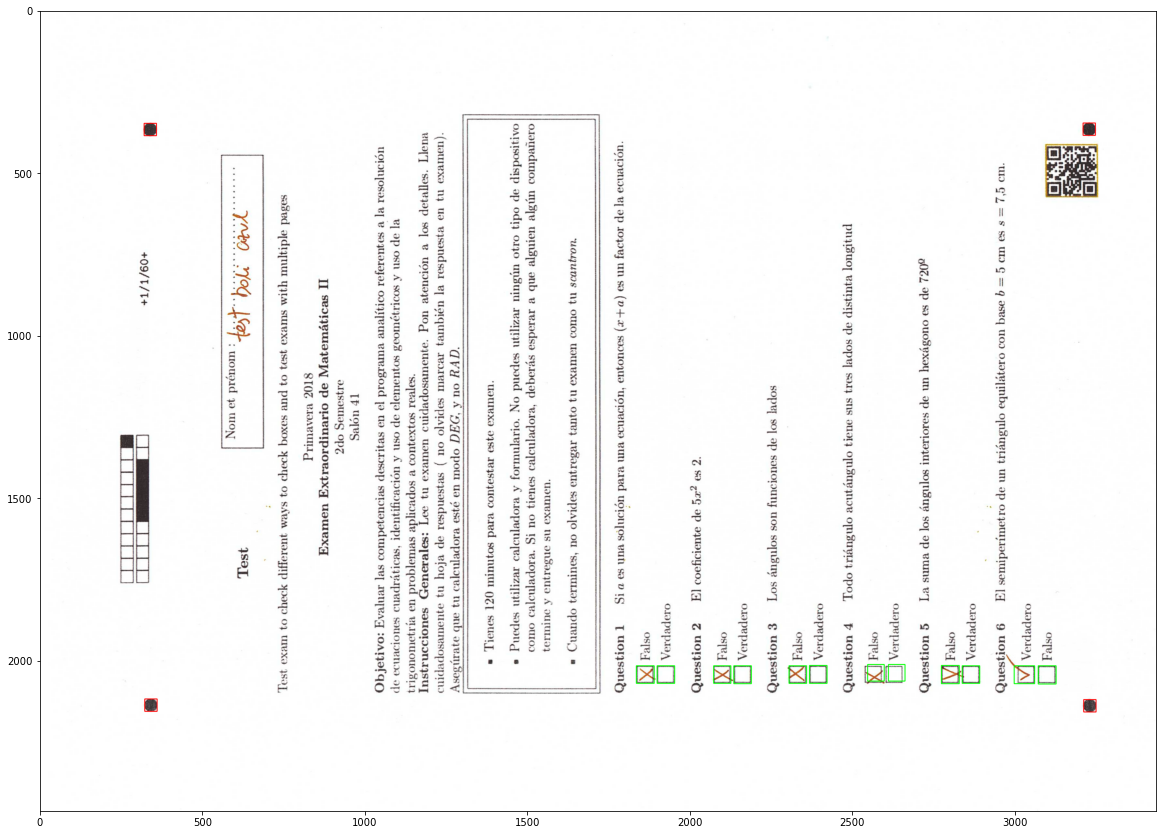

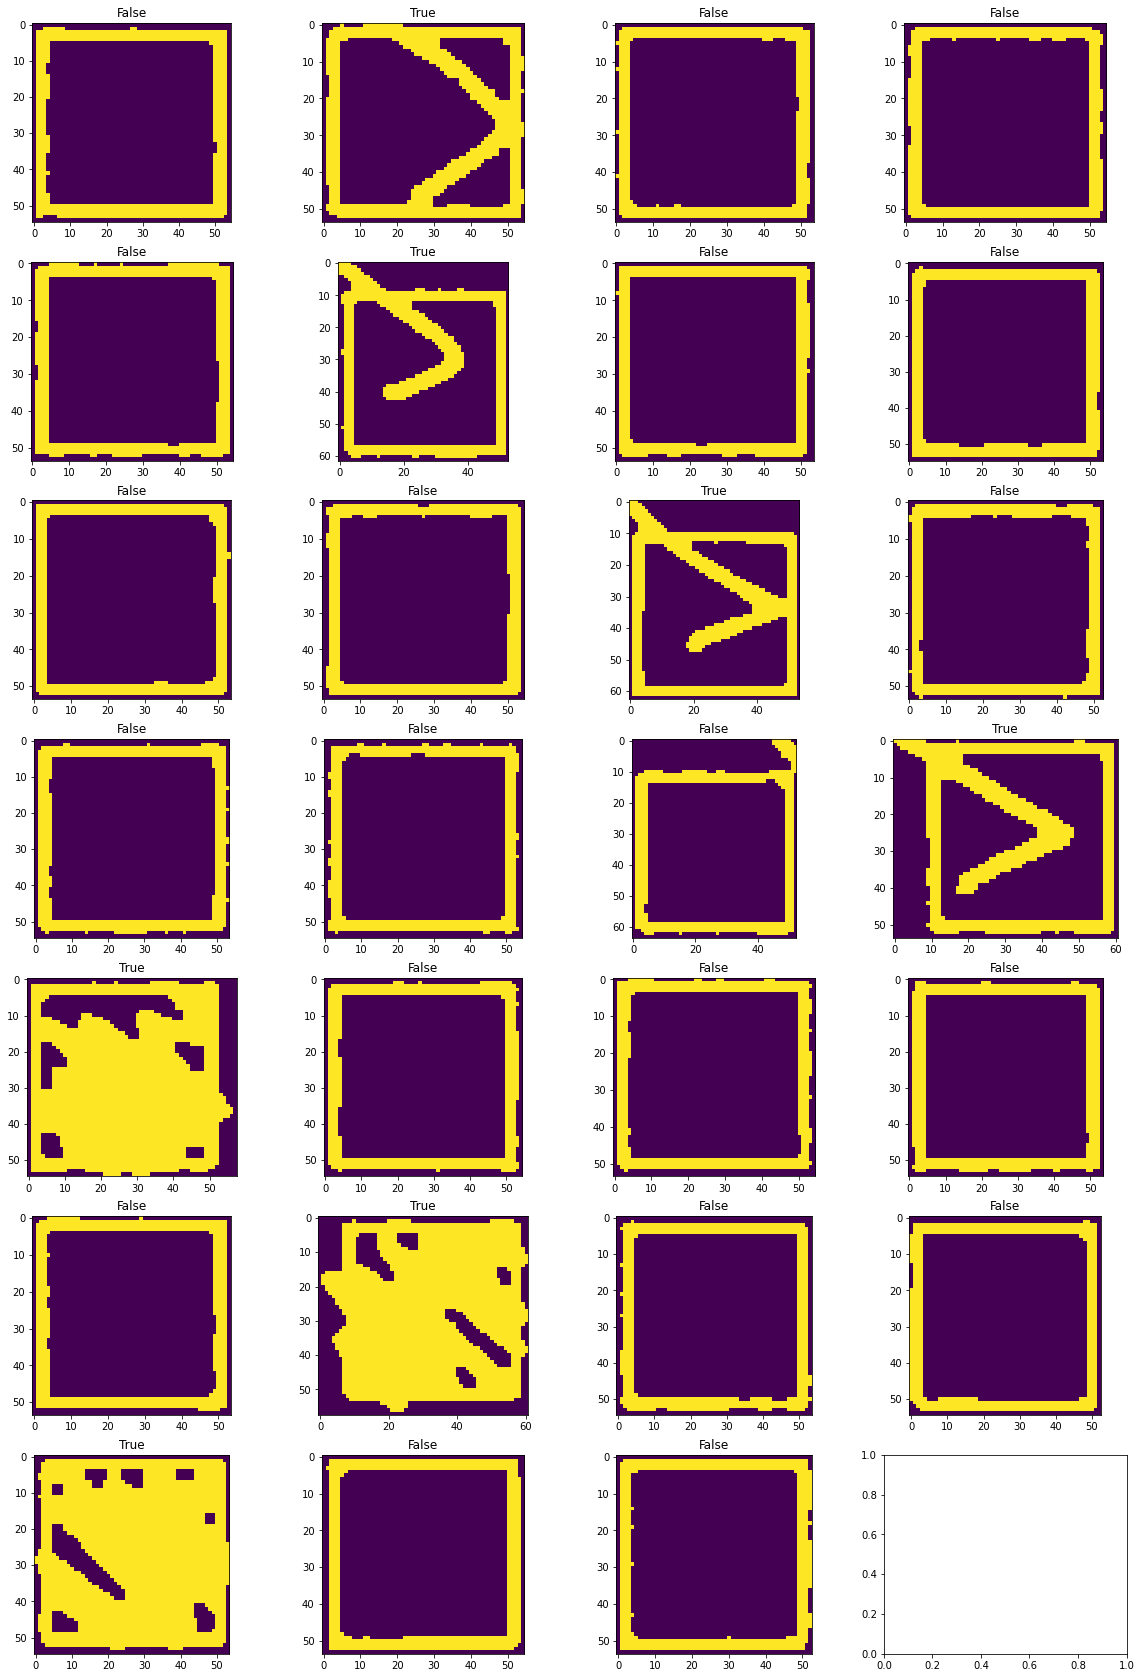

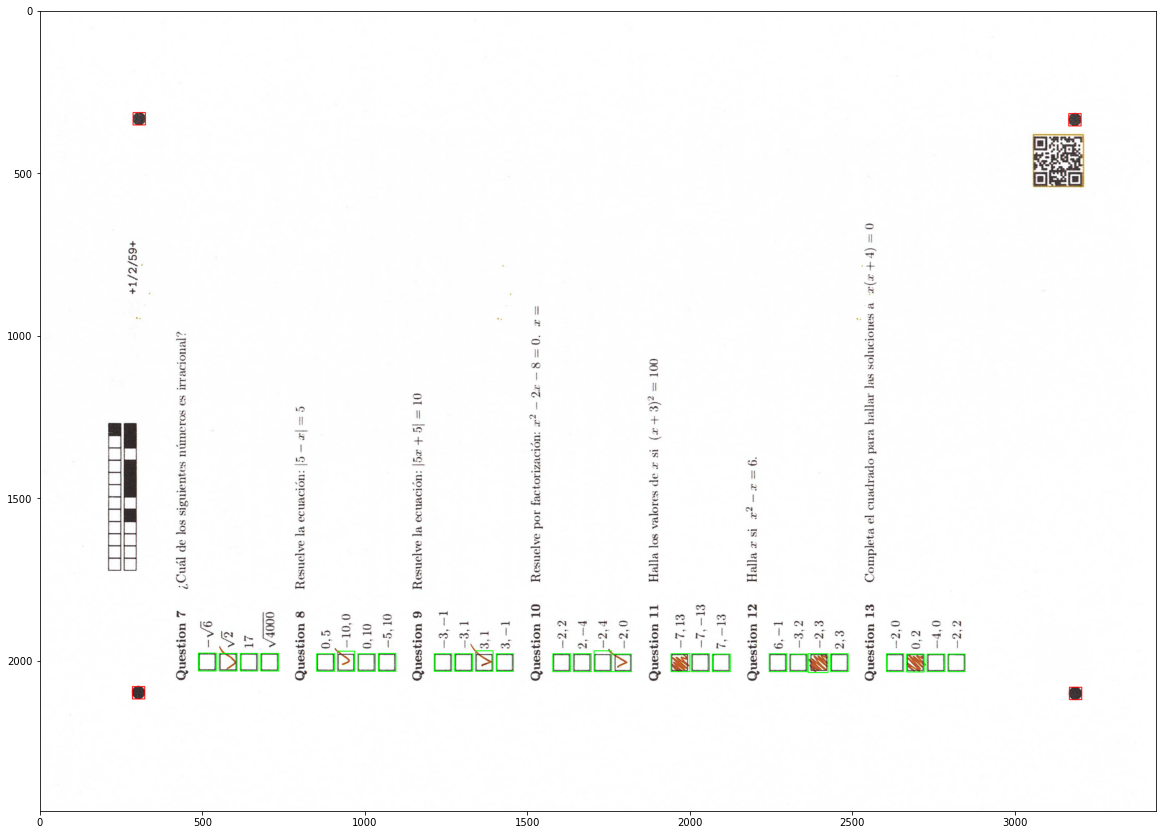

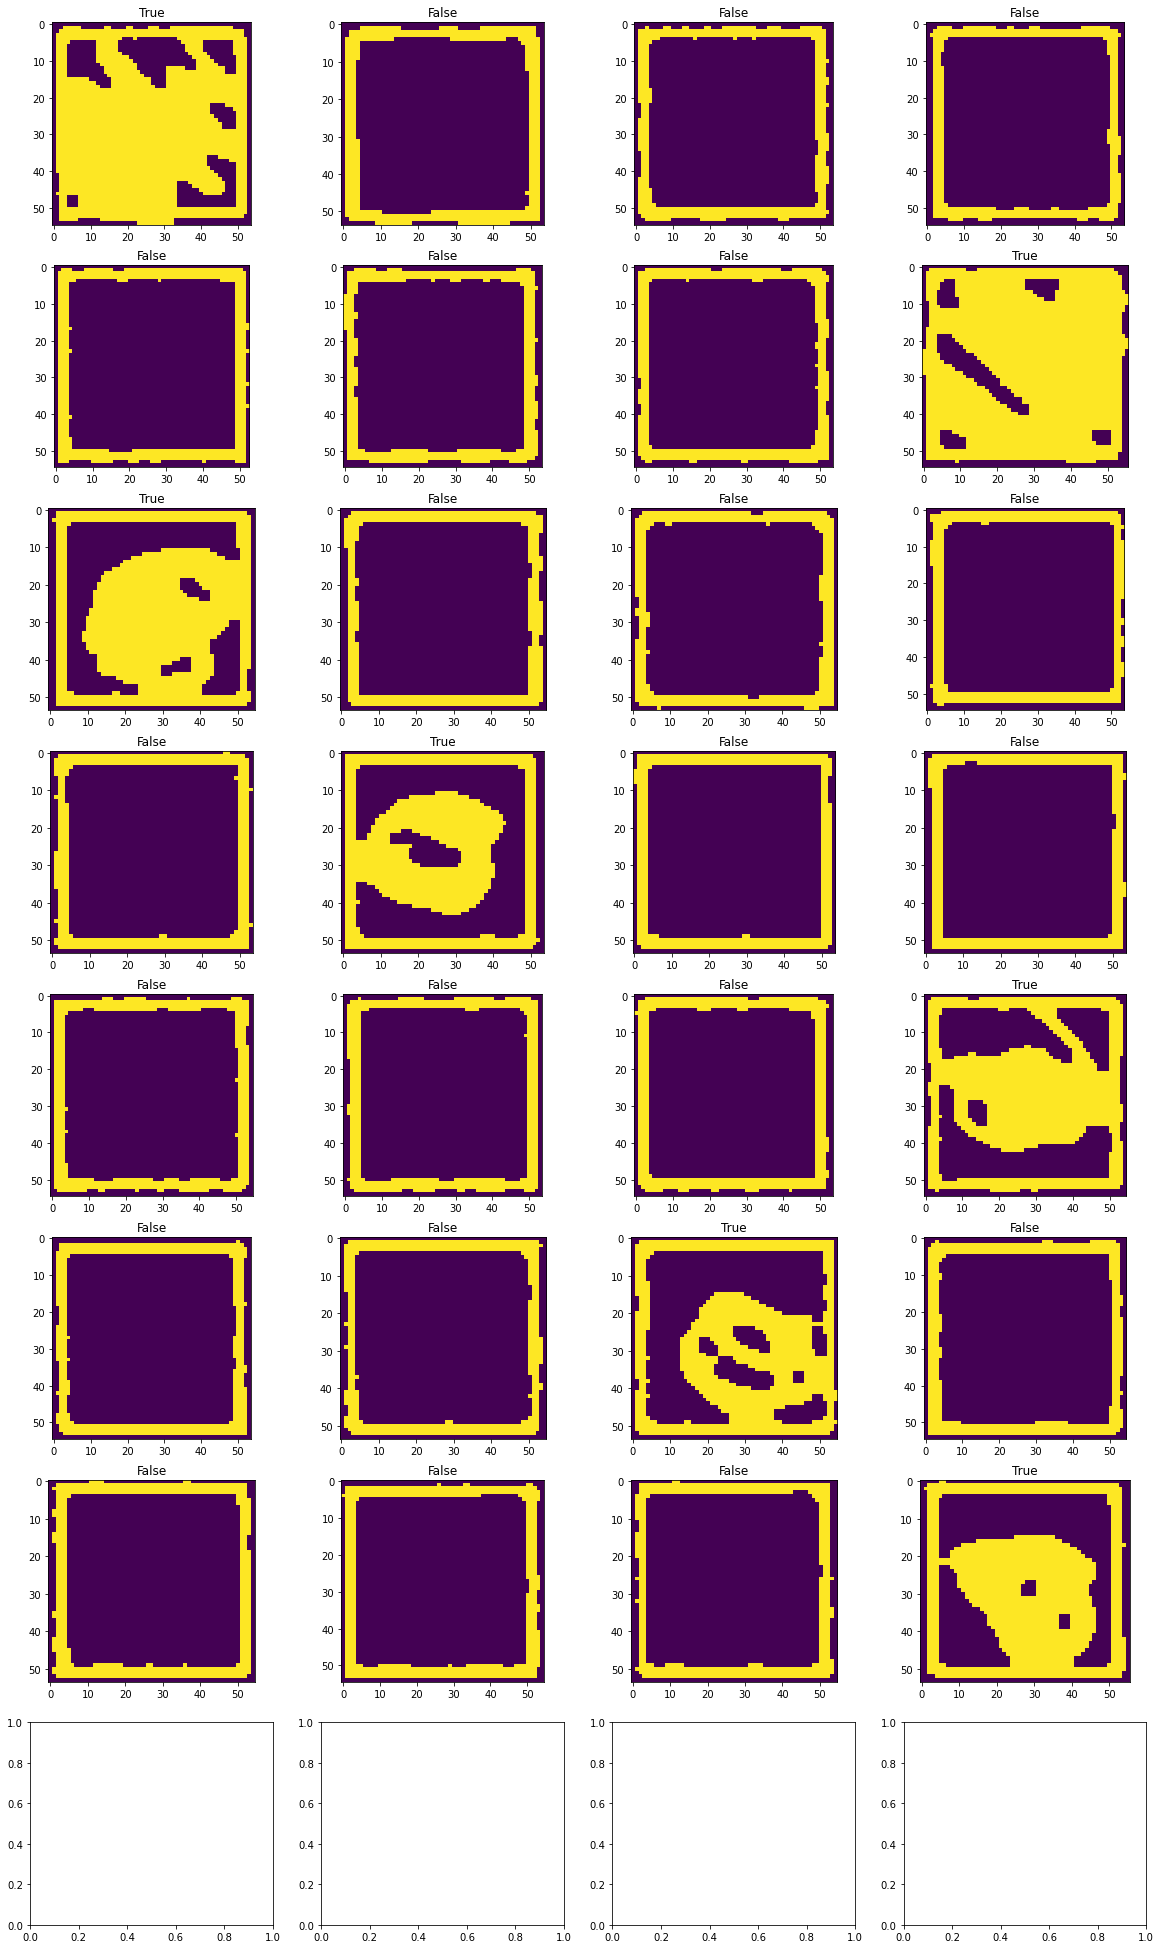

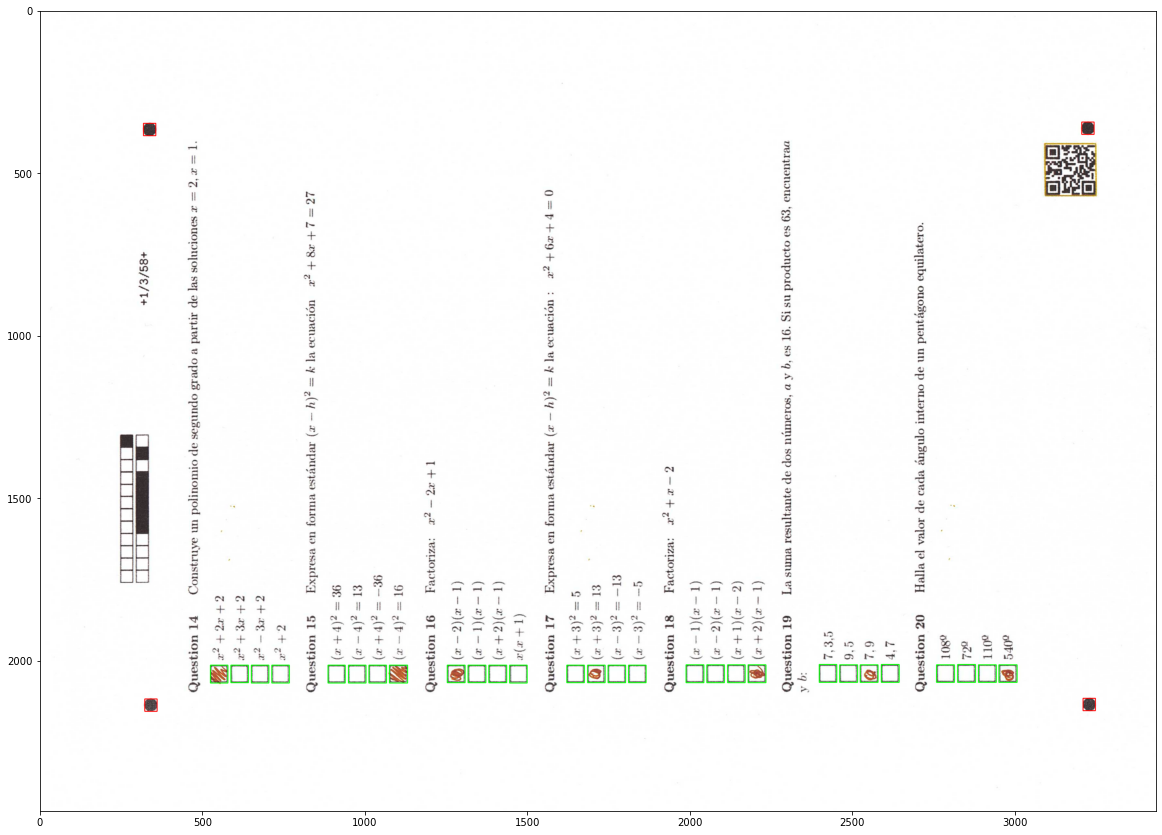

{'exam': 'test_qr',
 'variant': '22222',
 'num_boxes': 67,
 'exercises': [[{'exercise': 'vf1',
    'checkboxes': [{'checkbox': '0,0',
      'cords': [1835, 2016, 55, 54],
      'page': '1',
      'is_marked': True},
     {'checkbox': '0,1',
      'cords': [1899, 2016, 54, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['0,0']},
   {'exercise': 'vf2',
    'checkboxes': [{'checkbox': '1,0',
      'cords': [2073, 2016, 53, 54],
      'page': '1',
      'is_marked': True},
     {'checkbox': '1,1',
      'cords': [2135, 2016, 54, 55],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['1,0']},
   {'exercise': 'vf3',
    'checkboxes': [{'checkbox': '2,0',
      'cords': [2305, 2016, 54, 54],
      'page': '1',
      'is_marked': True},
     {'checkbox': '2,1',
      'cords': [2368, 2015, 54, 55],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['2,0']},
   {'exercise': 'vf4',
    'checkboxes': [{'checkbox': '3,0',
      'cord

In [250]:
anal_sc_test(ex_file2_rot90, 300, qrs2_rot90, data_st1)

In [251]:
qrs2_rot180

[{'exam': 'test_qr',
  'variant': '22222',
  'page': '1',
  'coordinates': array([[[570.     , 333.     ],
          [419.27383, 335.9962 ],
          [414.     , 182.     ],
          [570.9286 , 182.     ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '22222',
  'page': '2',
  'coordinates': array([[[539.     , 375.     ],
          [389.     , 377.39807],
          [389.     , 228.02325],
          [540.     , 228.     ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '22222',
  'page': '3',
  'coordinates': array([[[567.     , 336.     ],
          [416.01947, 338.     ],
          [413.     , 183.     ],
          [565.     , 187.     ]]], dtype=float32)}]

In [252]:
default_cords_qr, qr_cords2_180

(array([[1950.00012207, 3174.        ],
        [2107.        , 3174.        ],
        [2107.        , 3331.        ],
        [1950.00012207, 3331.        ]]),
 array([[570.        , 333.        ],
        [419.27383423, 335.9961853 ],
        [414.        , 182.        ],
        [570.92858887, 182.        ]]))

In [253]:
get_trans(default_cords_qr, qr_cords2_180)

(array([2510.77730138, 3407.93298911]), 179.3130420464907, 0.9757549200644493)

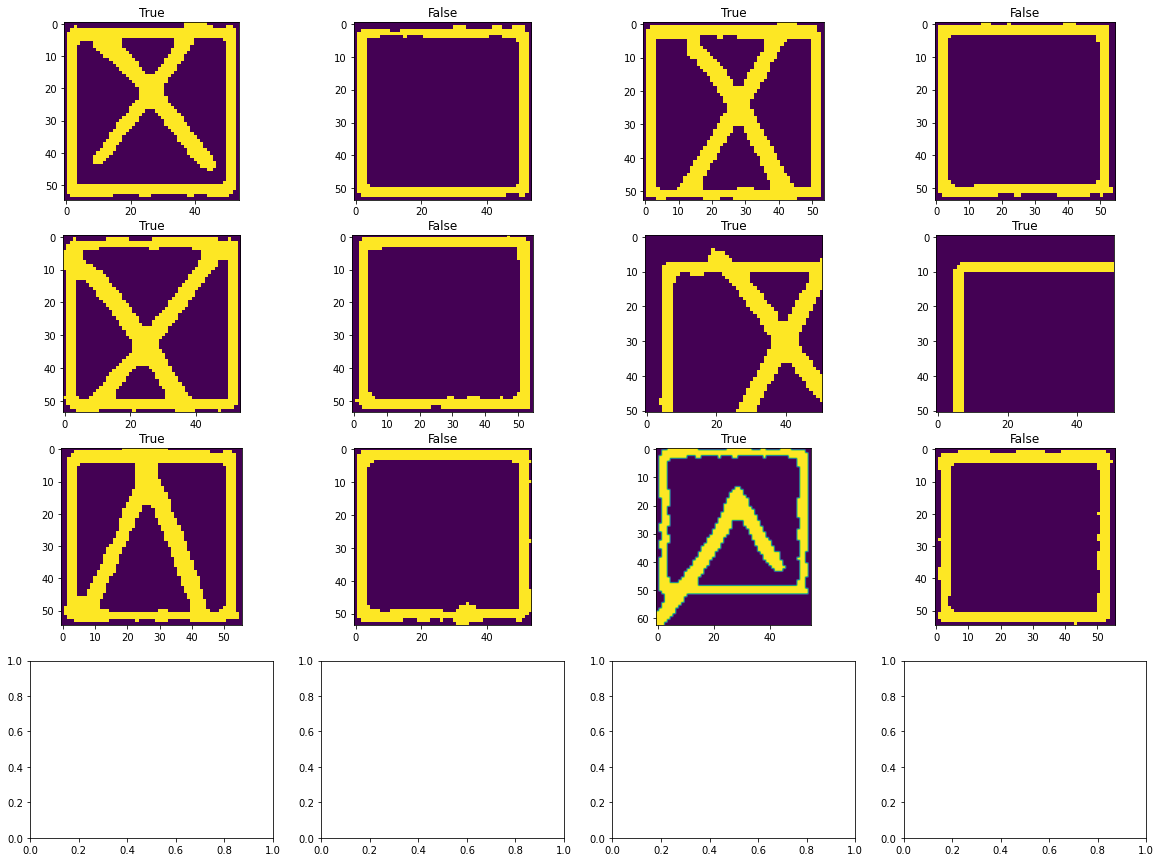

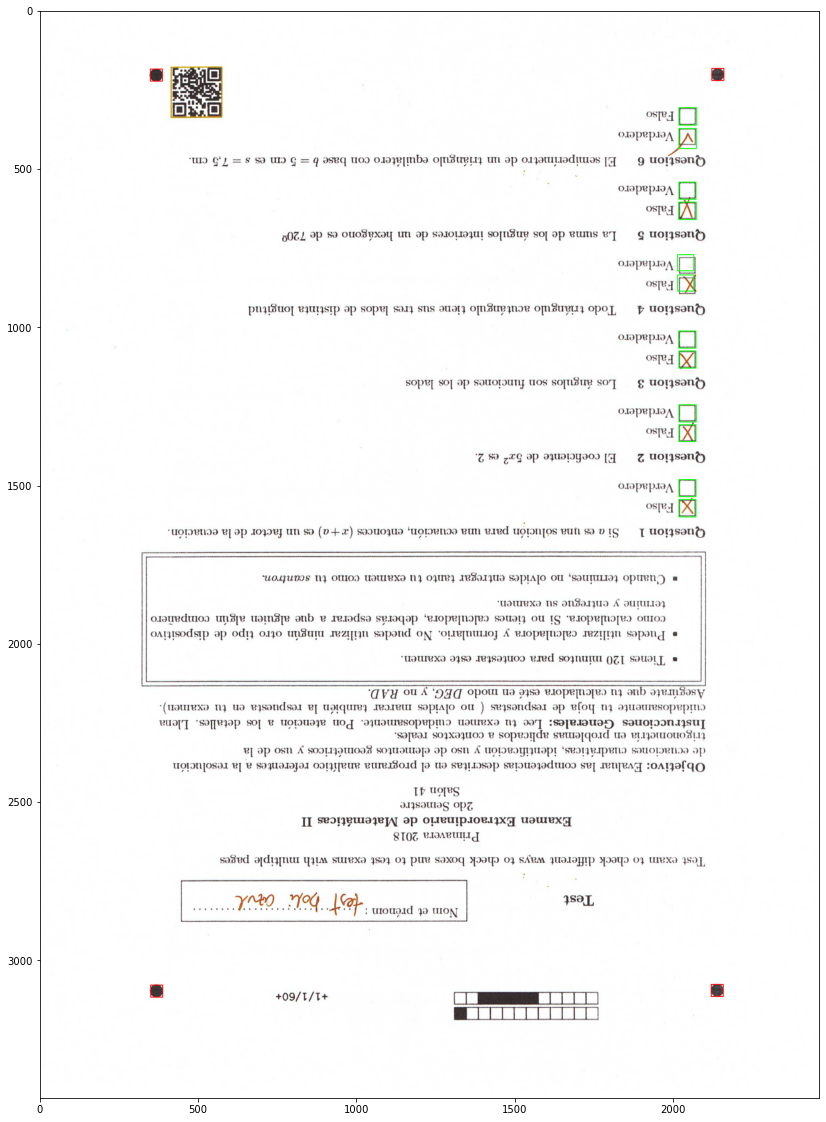

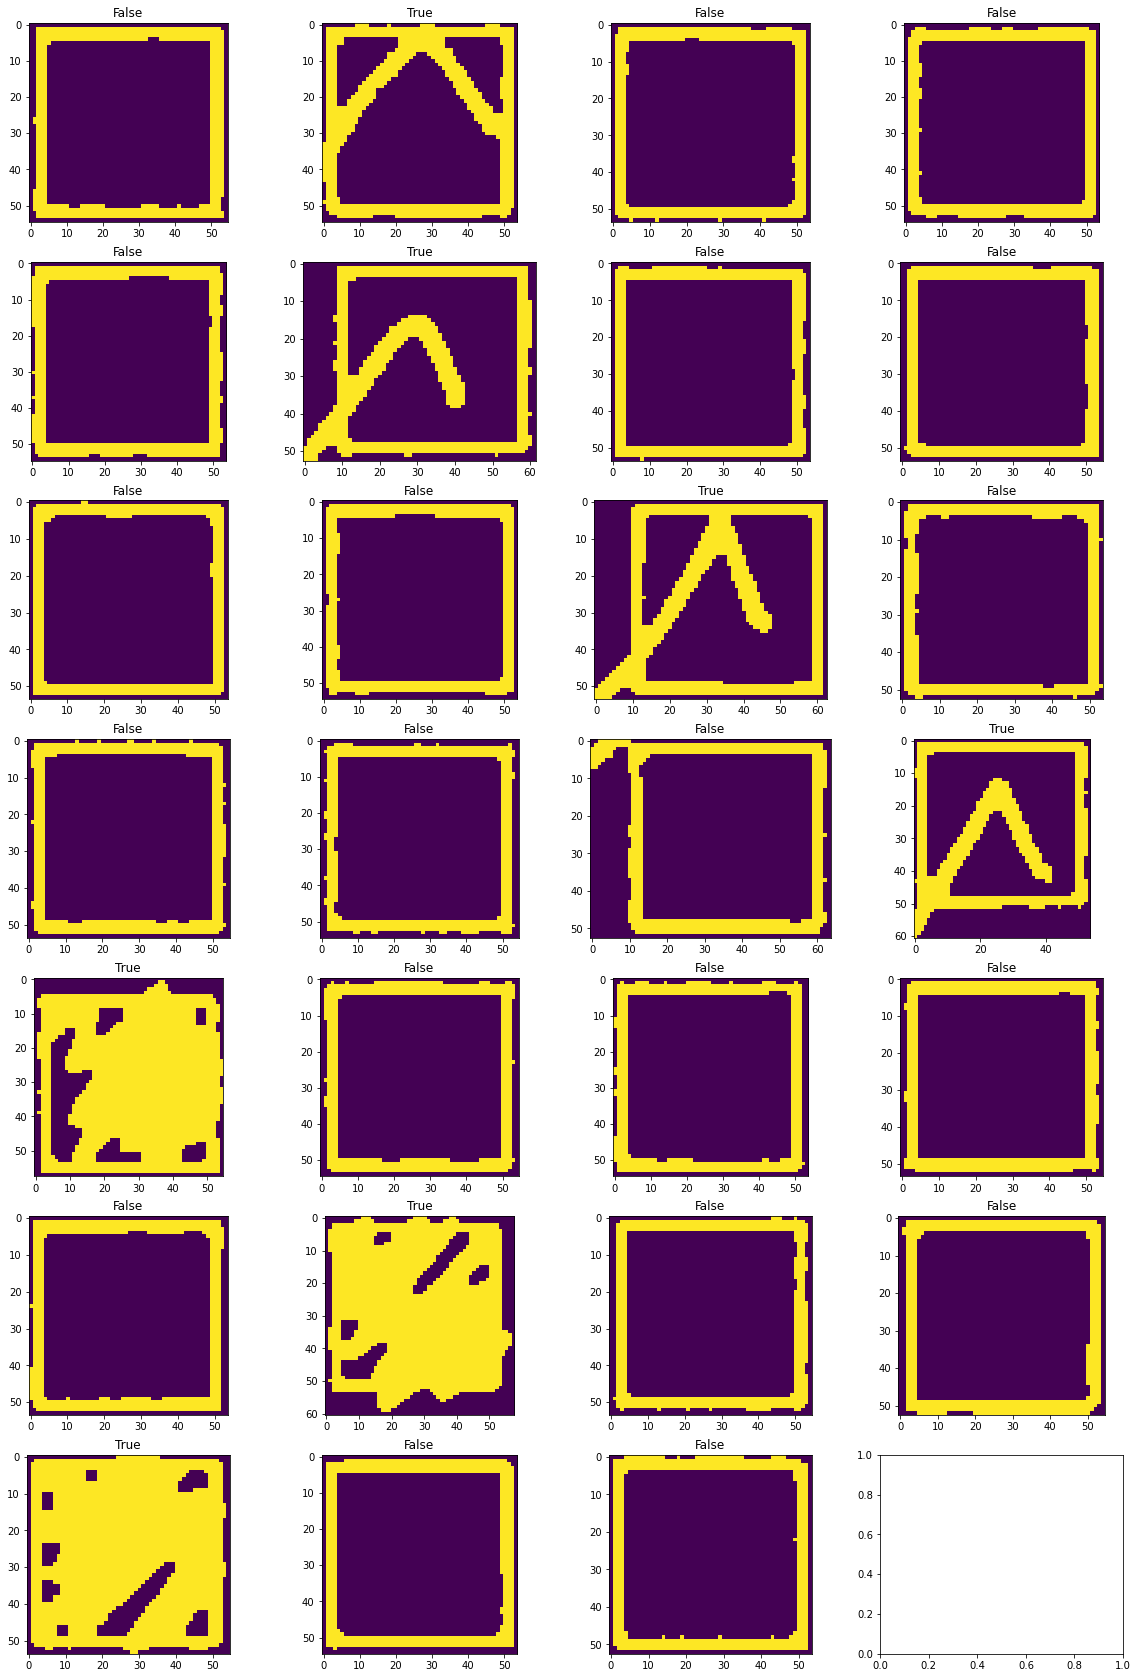

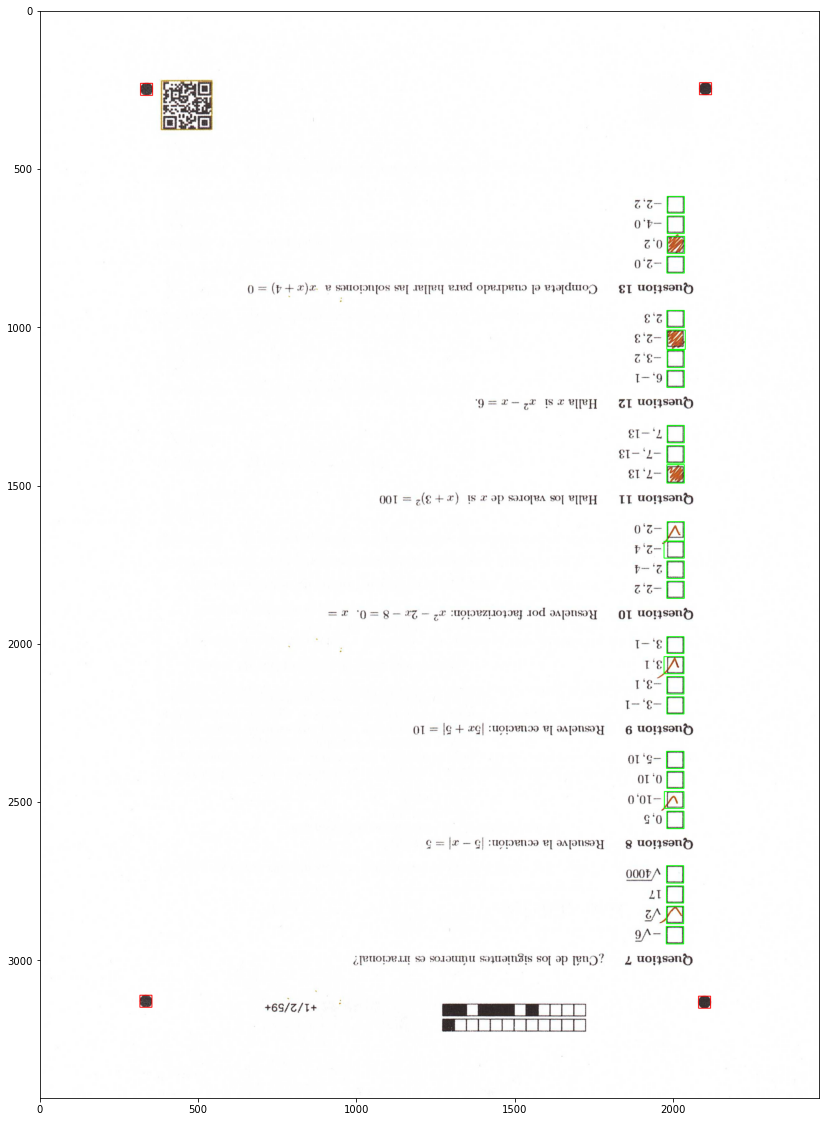

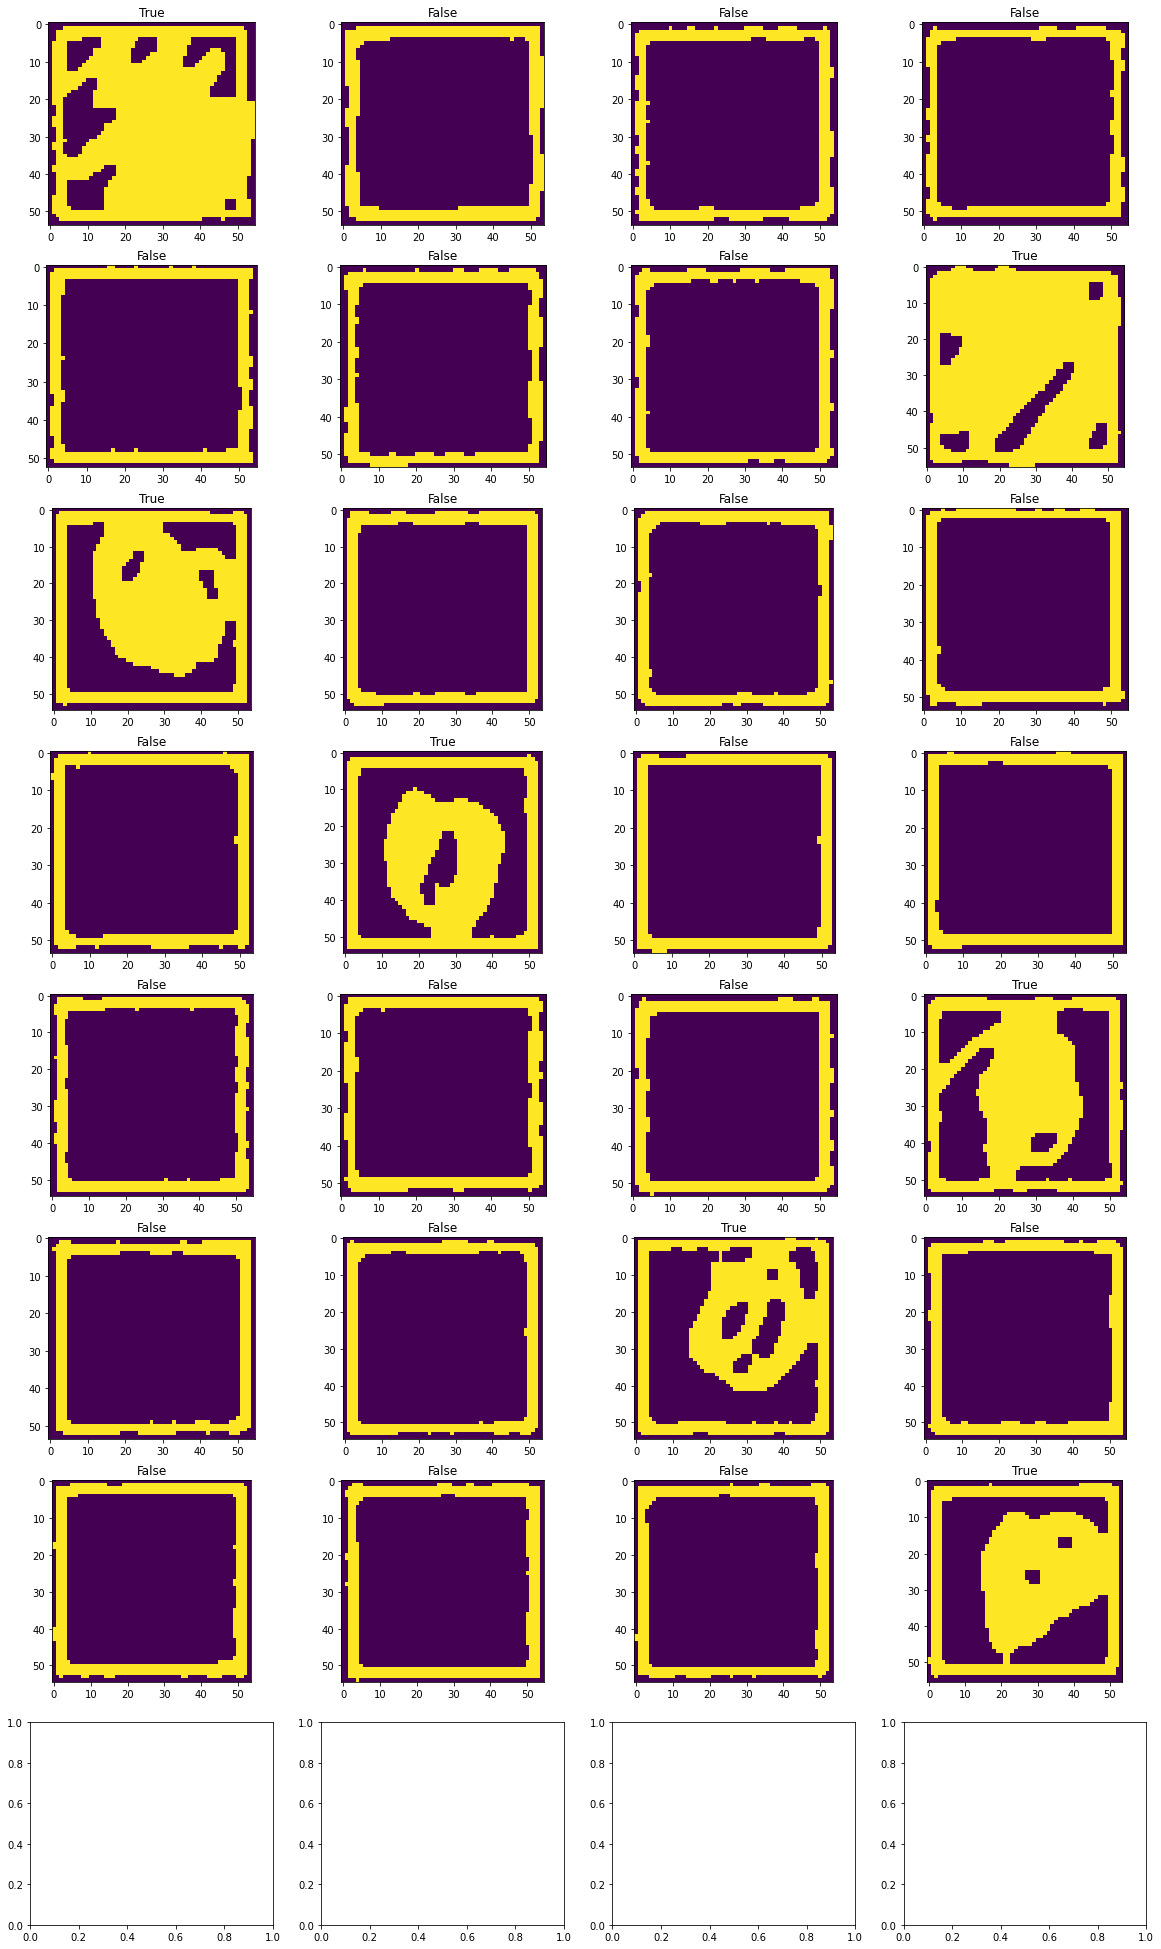

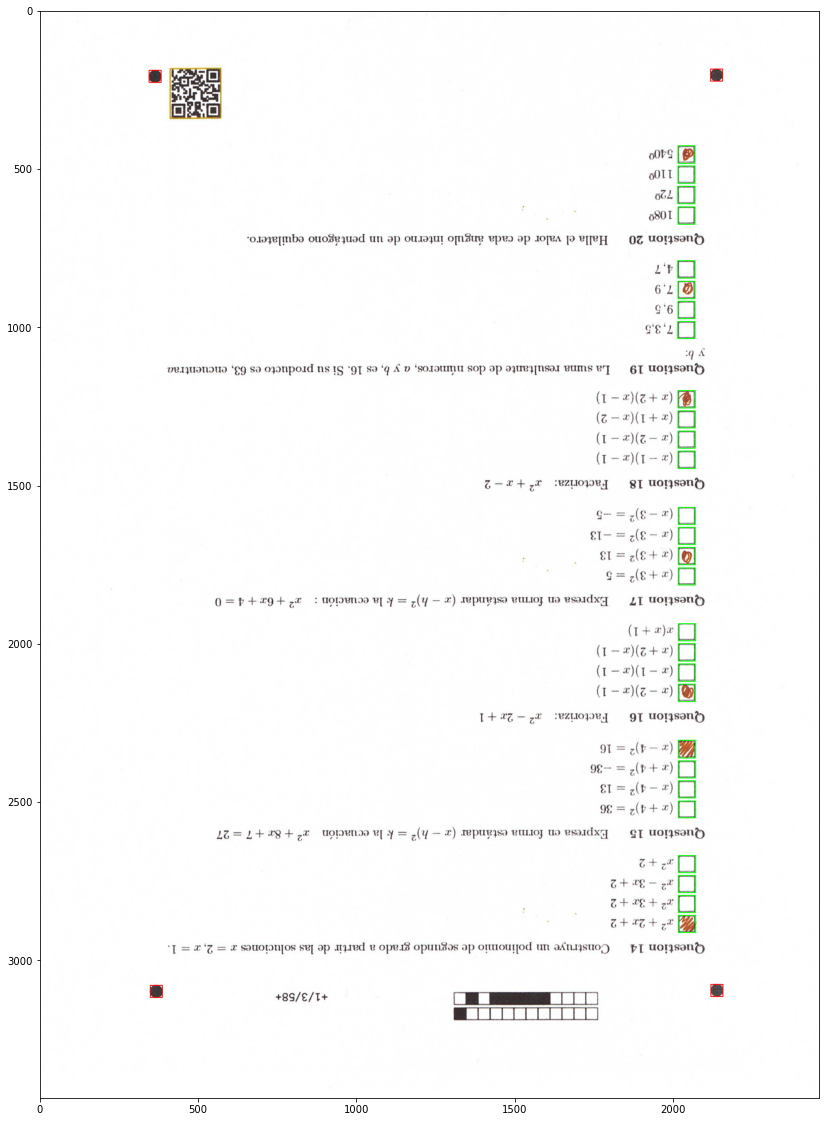

{'exam': 'test_qr',
 'variant': '22222',
 'num_boxes': 67,
 'exercises': [[{'exercise': 'vf1',
    'checkboxes': [{'checkbox': '0,0',
      'cords': [2017, 1545, 54, 55],
      'page': '1',
      'is_marked': True},
     {'checkbox': '0,1',
      'cords': [2017, 1482, 54, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['0,0']},
   {'exercise': 'vf2',
    'checkboxes': [{'checkbox': '1,0',
      'cords': [2017, 1309, 54, 53],
      'page': '1',
      'is_marked': True},
     {'checkbox': '1,1',
      'cords': [2017, 1246, 55, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['1,0']},
   {'exercise': 'vf3',
    'checkboxes': [{'checkbox': '2,0',
      'cords': [2017, 1076, 54, 54],
      'page': '1',
      'is_marked': True},
     {'checkbox': '2,1',
      'cords': [2016, 1013, 55, 54],
      'page': '1',
      'is_marked': False}],
    'student_marked': ['2,0']},
   {'exercise': 'vf4',
    'checkboxes': [{'checkbox': '3,0',
      'cord

In [254]:
anal_sc_test(ex_file2_rot180, 300, qrs2_rot180, data_st1)

In [255]:
qrs2_rot45 = find_qrs('scanned/scanned_22222_rot45.pdf', 300)

In [256]:
qrs2_rot45

[{'exam': '',
  'variant': '',
  'page': '',
  'coordinates': array([[[1370.    , 3238.    ],
          [1477.    , 3341.    ],
          [1370.9999, 3463.    ],
          [1267.    , 3346.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '22222',
  'page': '2',
  'coordinates': array([[[1327.4867, 3184.5317],
          [1432.    , 3291.    ],
          [1325.8109, 3396.9312],
          [1222.    , 3286.    ]]], dtype=float32)},
 {'exam': 'test_qr',
  'variant': '22222',
  'page': '3',
  'coordinates': array([[[1314., 3194.],
          [1419., 3300.],
          [1312., 3411.],
          [1207., 3298.]]], dtype=float32)}]

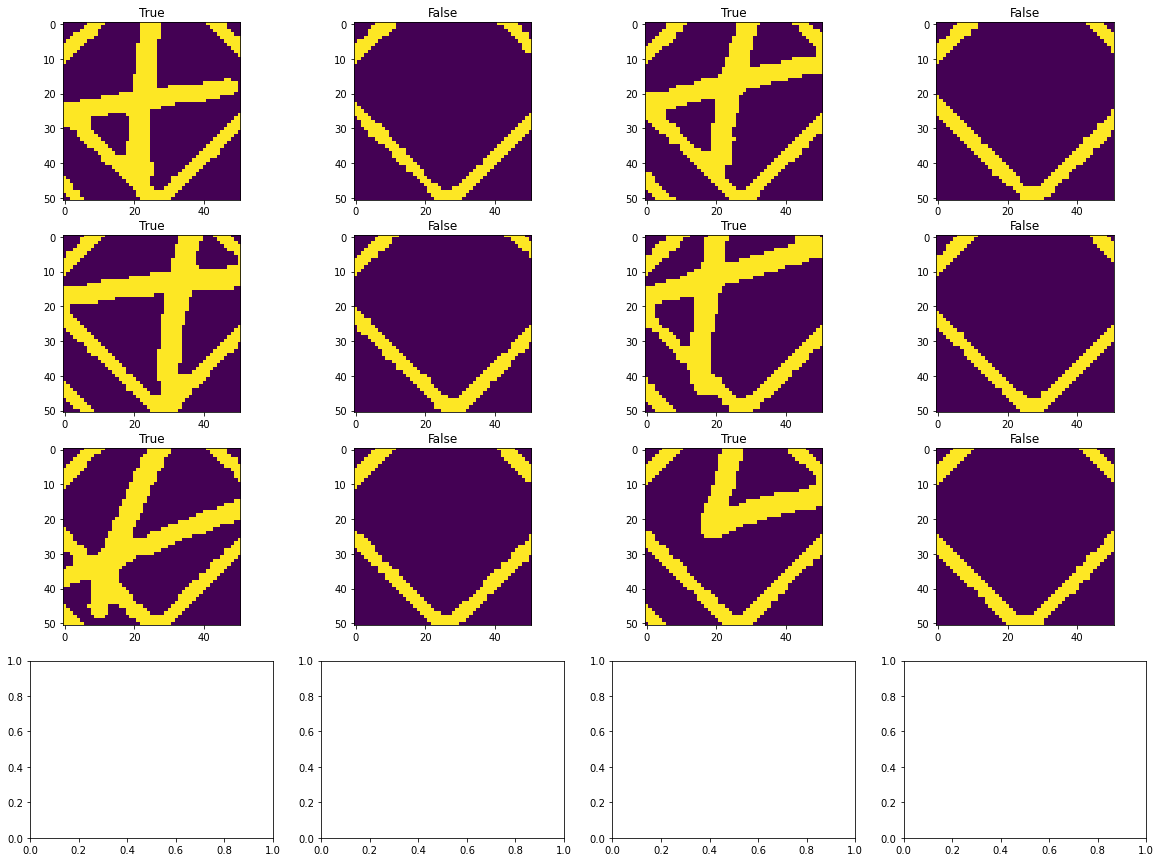

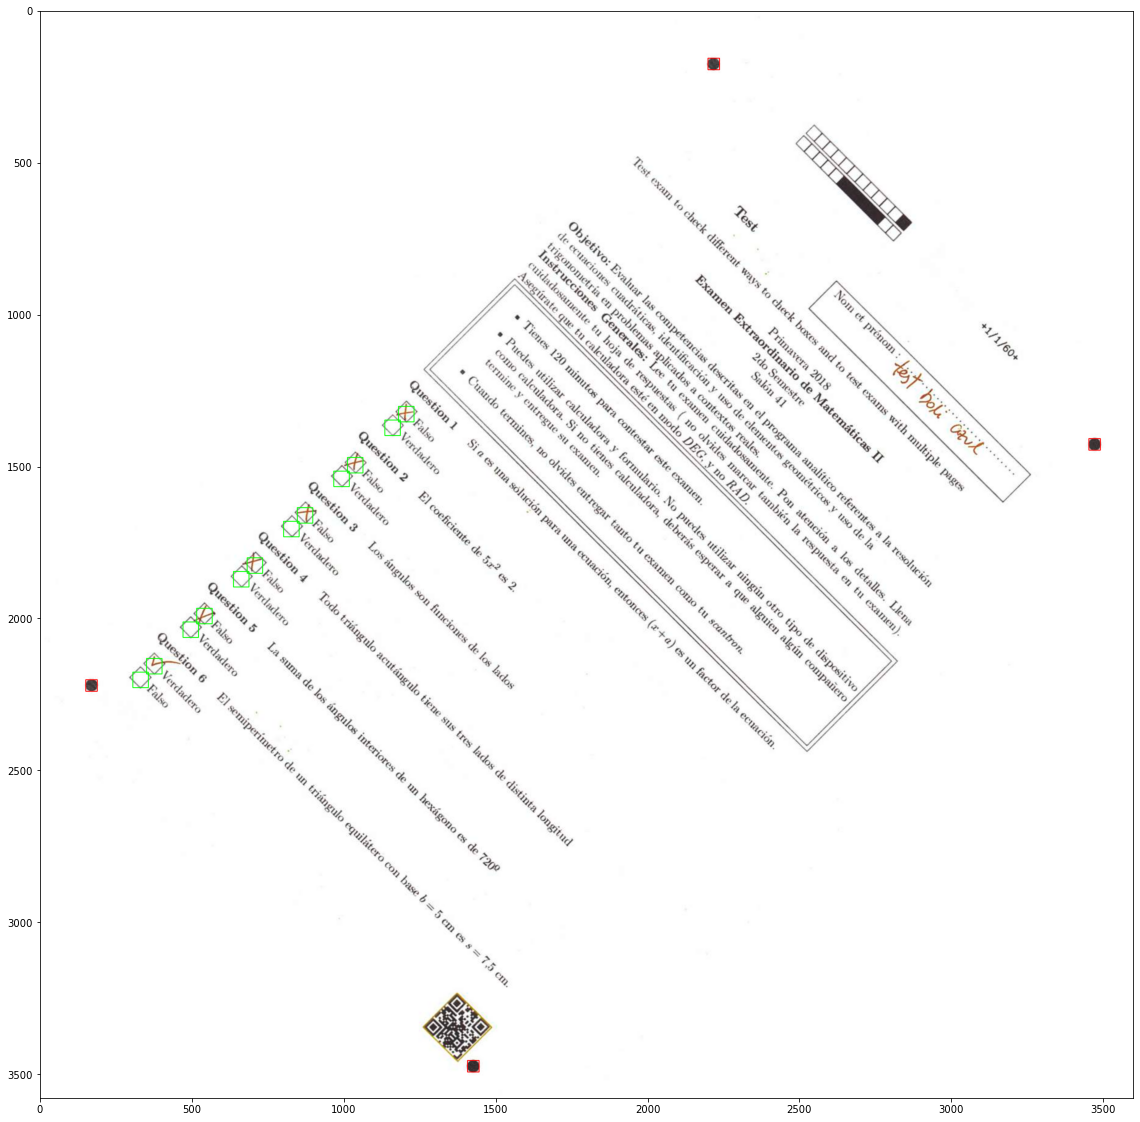

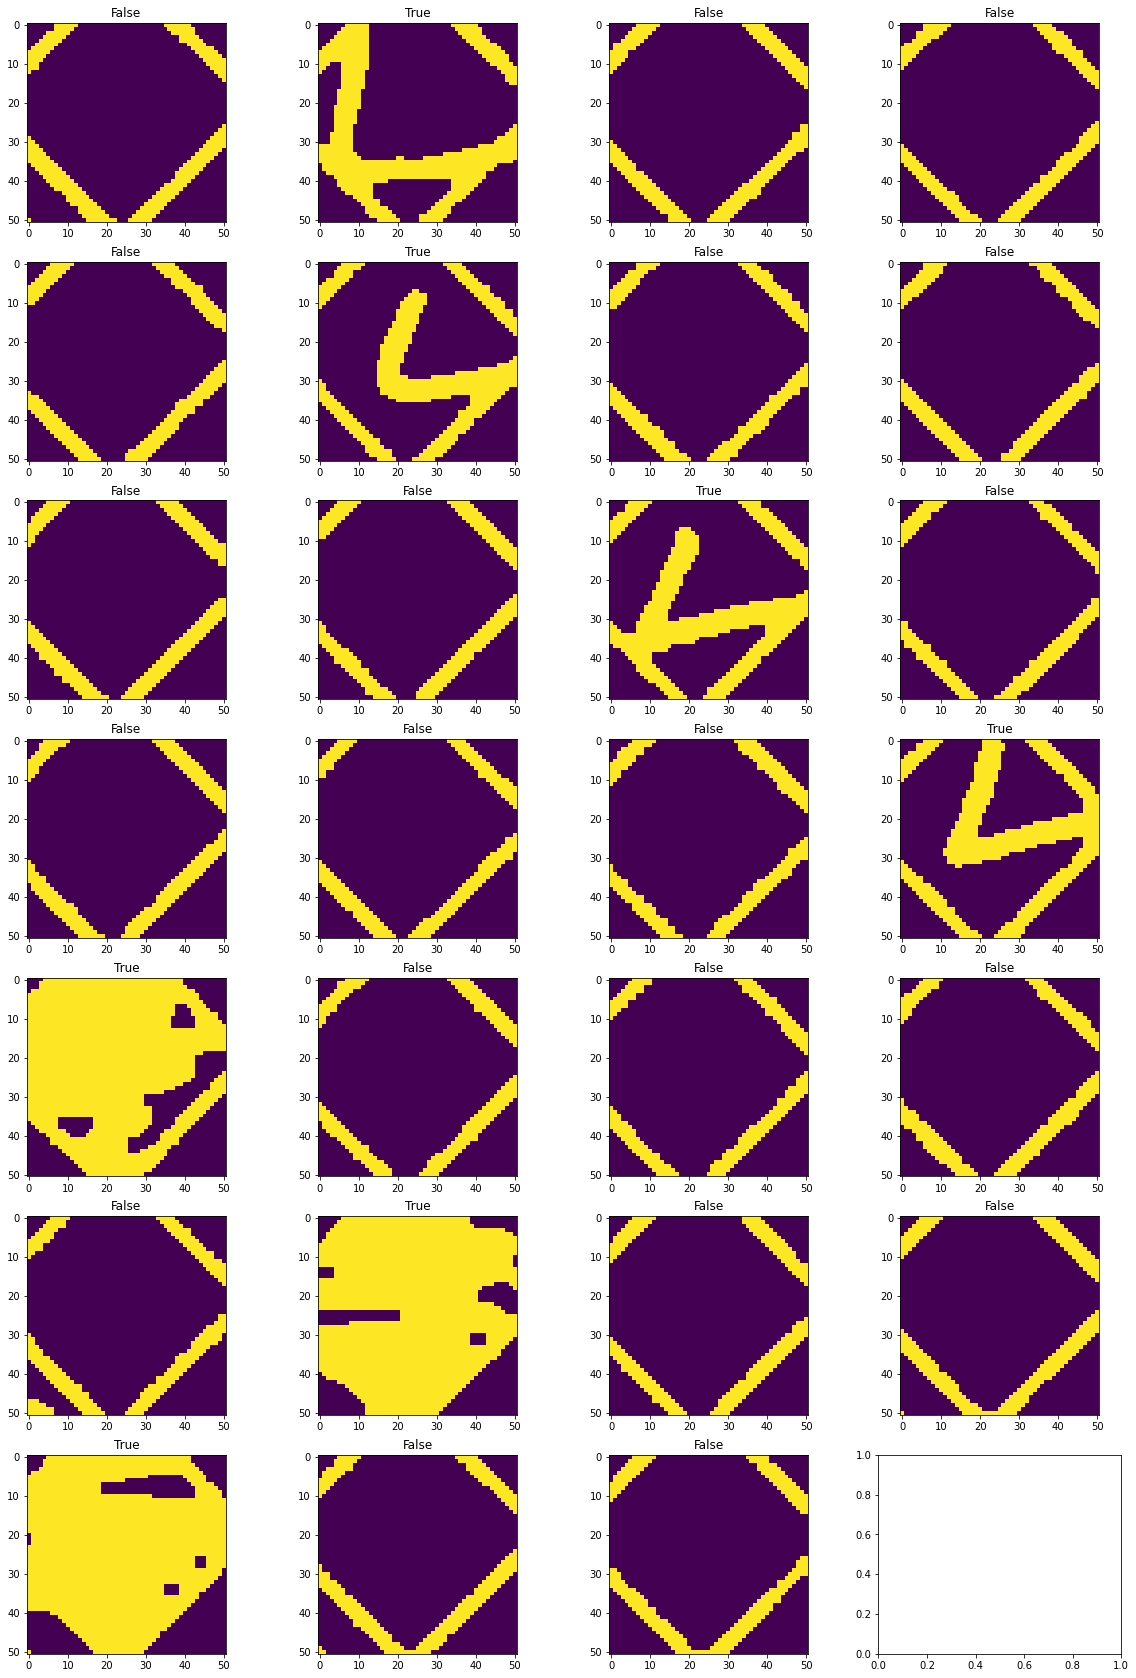

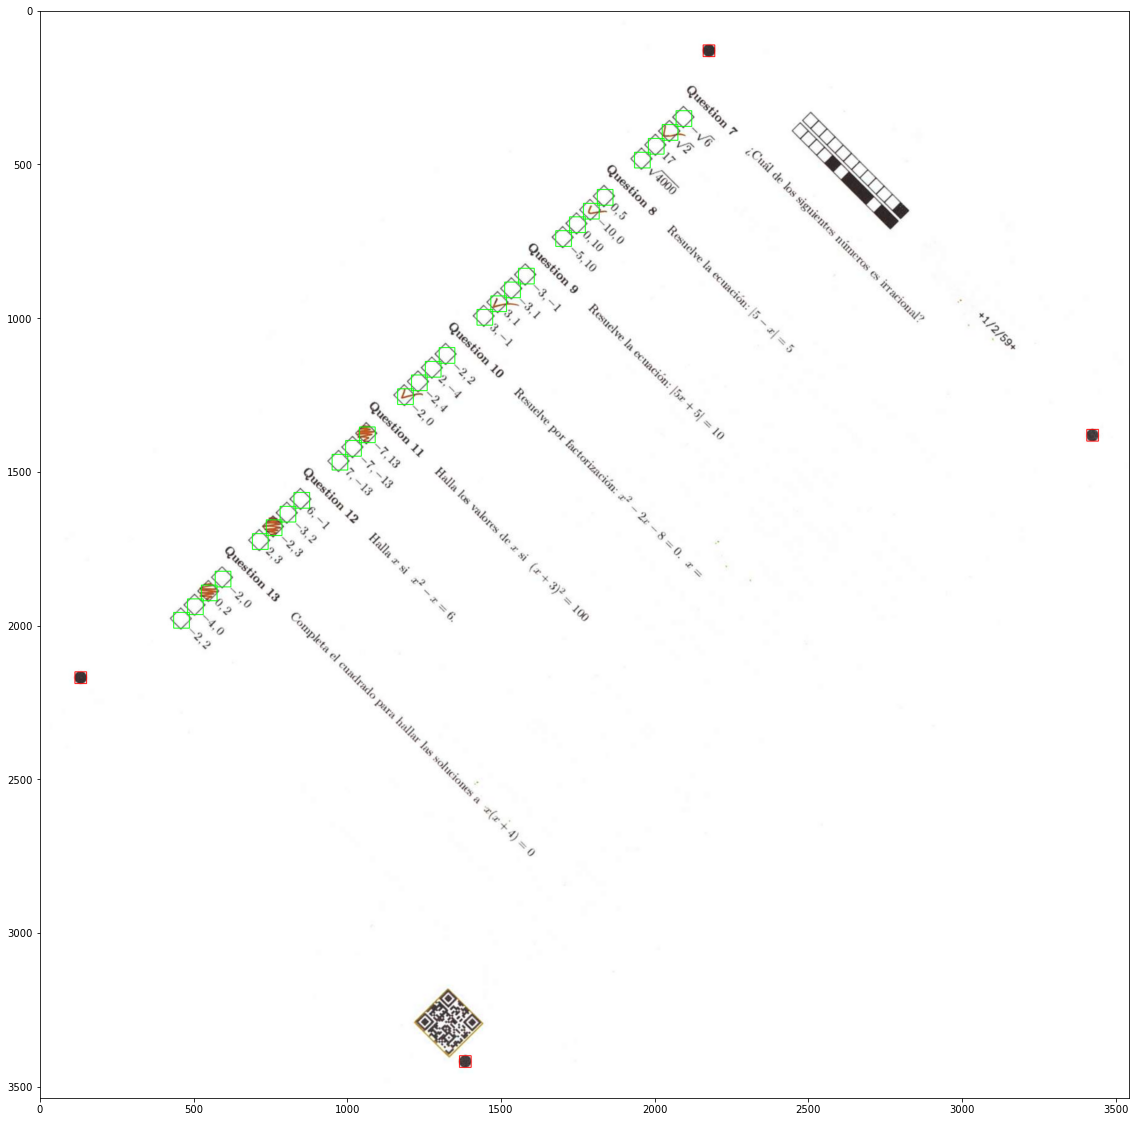

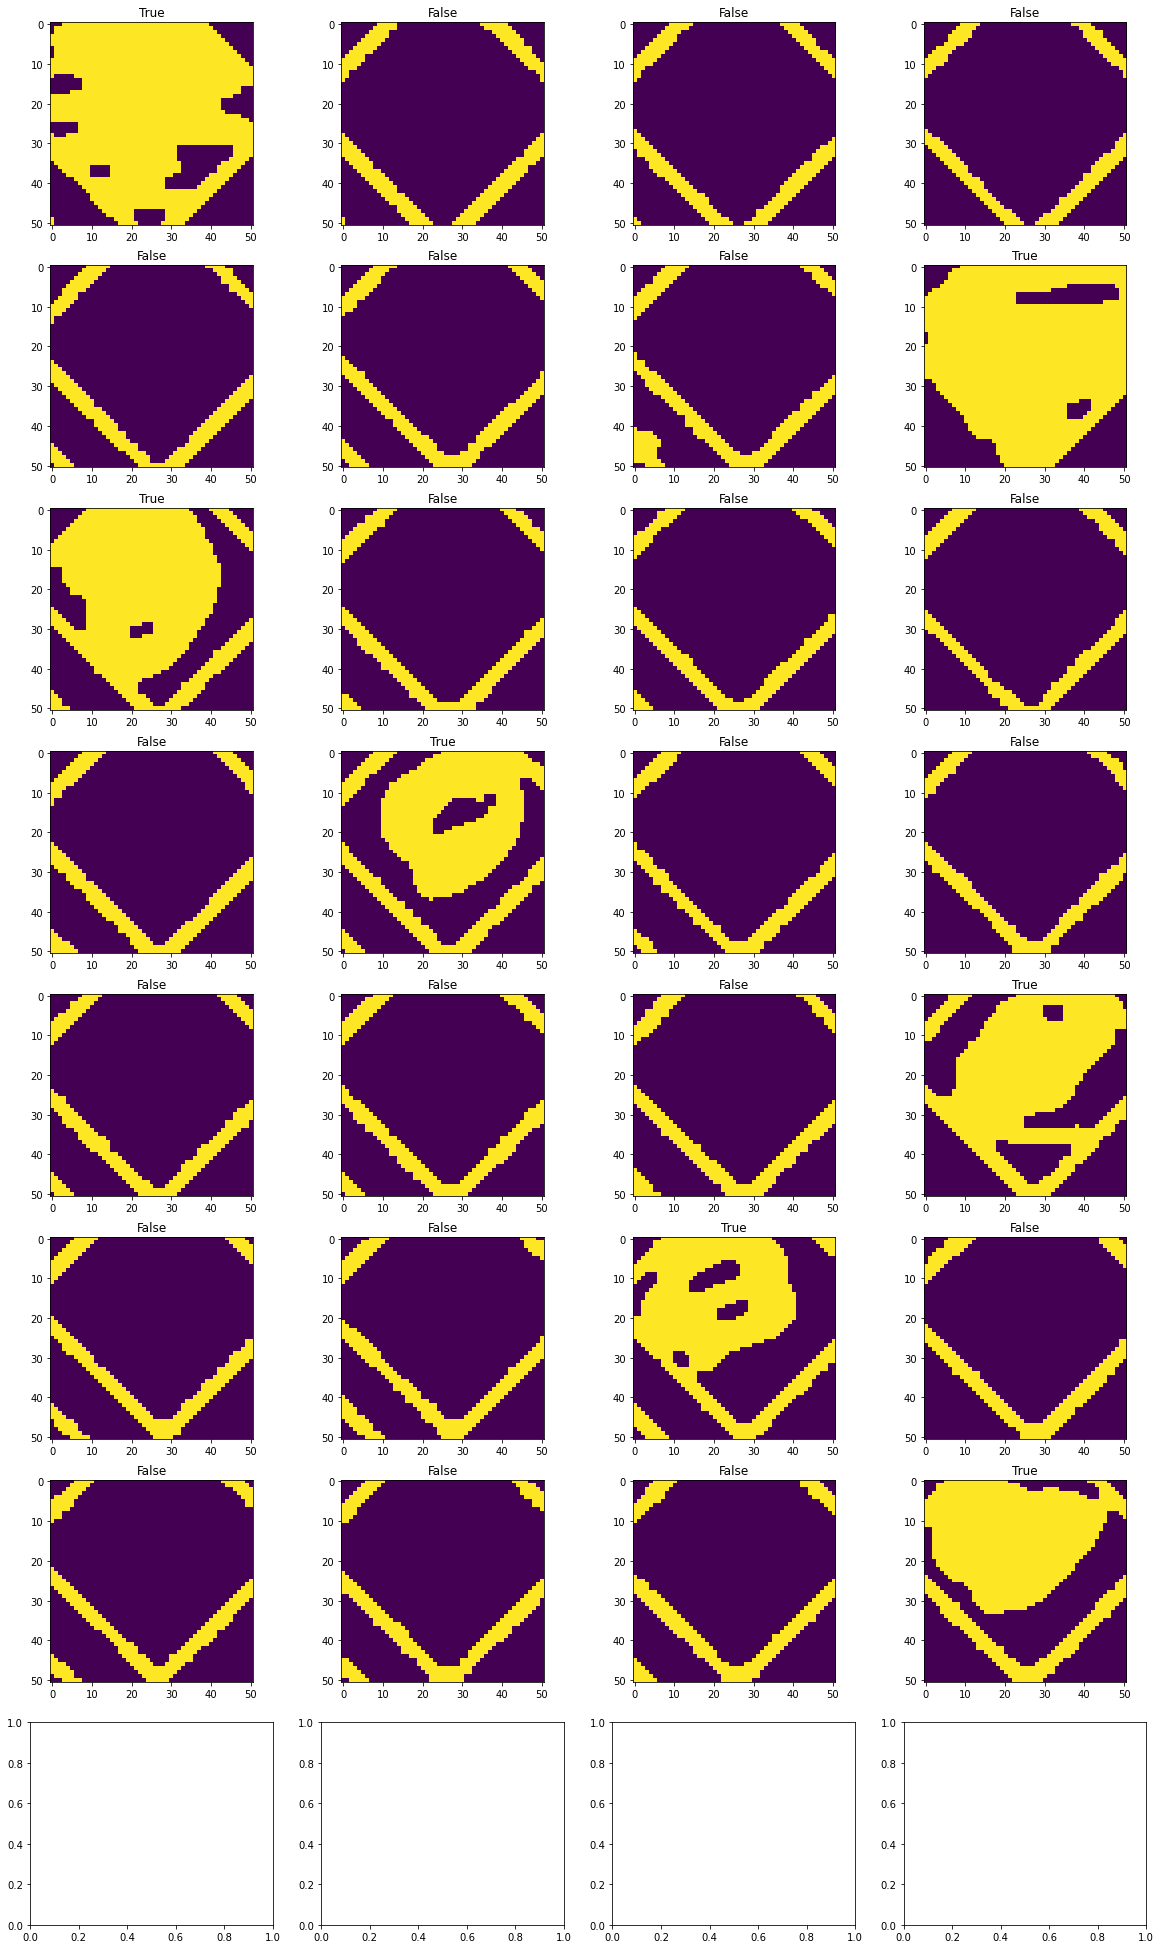

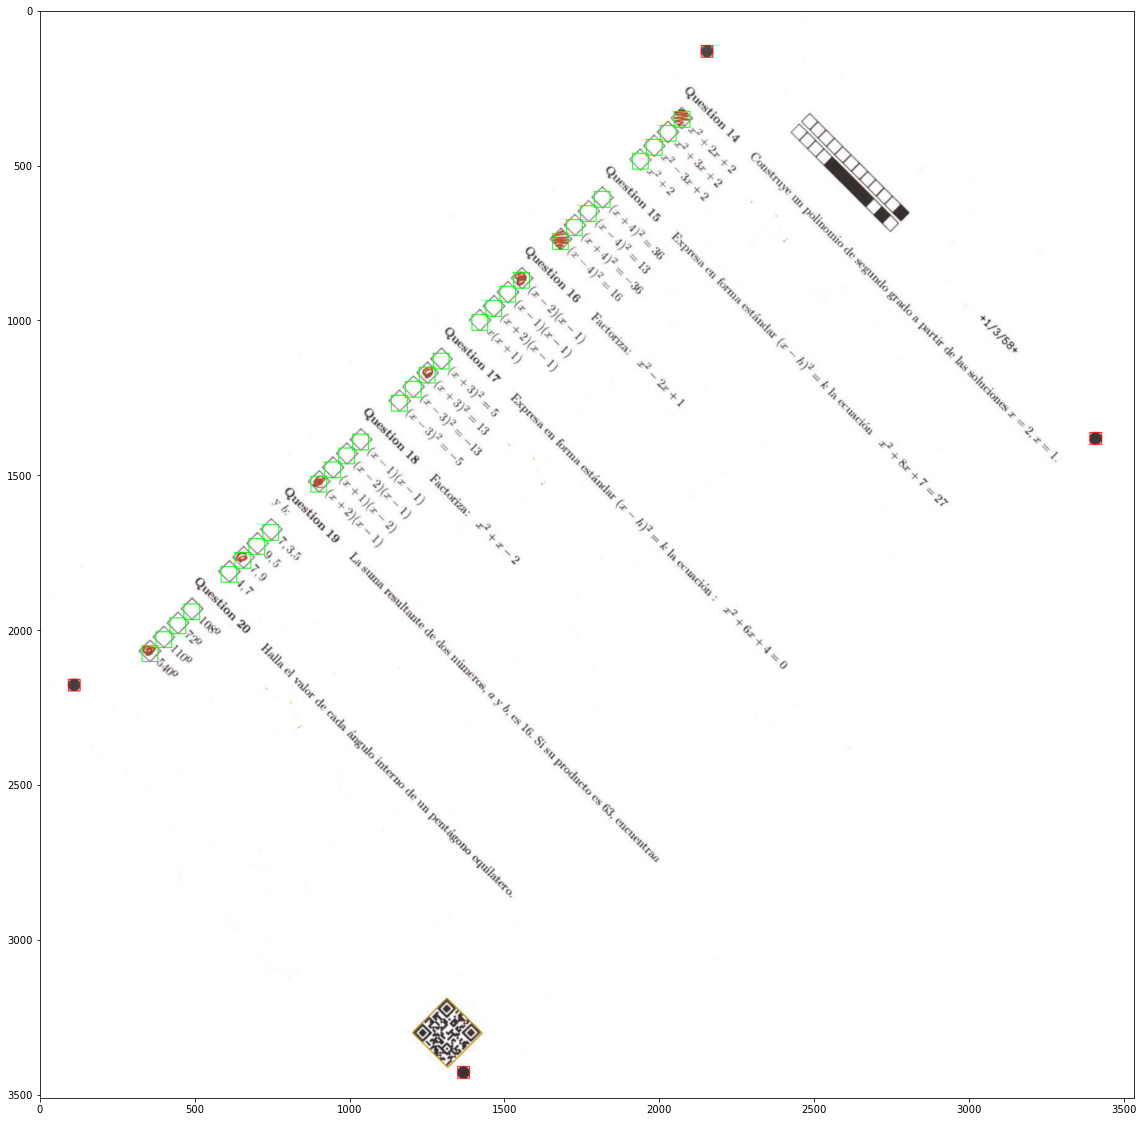

{'exam': '',
 'variant': '',
 'num_boxes': 67,
 'exercises': [[{'exercise': 'vf1',
    'checkboxes': [{'checkbox': '0,0',
      'cords': [1179.1735859962369, 1303.00006431014, 51, 51],
      'page': '',
      'is_marked': True},
     {'checkbox': '0,1',
      'cords': [1134.1666500603865, 1348.0598943926059, 51, 51],
      'page': '',
      'is_marked': False}],
    'student_marked': ['0,0']},
   {'exercise': 'vf2',
    'checkboxes': [{'checkbox': '1,0',
      'cords': [1011.0159274896173, 1471.3553491527587, 51, 51],
      'page': '',
      'is_marked': True},
     {'checkbox': '1,1',
      'cords': [966.0089915537665, 1516.4151792352247, 51, 51],
      'page': '',
      'is_marked': False}],
    'student_marked': ['1,0']},
   {'exercise': 'vf3',
    'checkboxes': [{'checkbox': '2,0',
      'cords': [846.2239068522276, 1636.3410406792984, 51, 51],
      'page': '',
      'is_marked': True},
     {'checkbox': '2,1',
      'cords': [801.2169709163772, 1681.4008707617645, 51, 51],
      

In [257]:
anal_sc_test('scanned/scanned_22222_rot45.pdf', 300, qrs2_rot45, data_st1)